# Amostragem de Índices da Bolsa Brasileira (Ibovespa, SMALL, IBrA)

## Importanto Bibliotecas

In [1]:
#!pip install yfinance
#!pip install selenium webdriver-managers
#!pip install unidecode

In [2]:
# Bibliotecas para análise de dados
import numpy as np
import pandas as pd

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.graph_objects as go

# Biblioteca ML
from sklearn.model_selection import StratifiedShuffleSplit

# Biblioteca para usar a API do Yahoo Finance
import yfinance as yf

# Bibliotecas auxiliares gerais
from time import sleep
from datetime import datetime
import os
import random
from pathlib import Path
import re
from unidecode import unidecode

# Bilbiotecas para webscrapping
import webbrowser
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Biblioteca para processamento em paralelo
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

## Obtendo dados dos índices no site da B3

In [3]:
# Função para buscar indíce no site da B3
def carteira_composicao_indice(indice, chrome_version = 112):
    """
    Abre a página do índice no site da B3, seleciona 'Setor de Atuação', clica no botão Download,
    salva o CSV como INDICE_YYYYMMDD.csv (sobrescrevendo se já existir) 
    e retorna o DataFrame.
    Exemplos de índices: IBOV, SMLL, IFIX, IBXX (IBrX100), IBXL (IBrX50), IBRA (IBrA)
    """

    print(f"\nInício Download dos ativos do índice {indice}")
  
    # Pasta de download
    pasta_download = os.path.join(os.getcwd(), f"dados_indice_{indice}")
    os.makedirs(pasta_download, exist_ok=True)
    
    # Nome do arquivo com data
    hoje = datetime.today().strftime("%Y%m%d")
    hoje_datetime = datetime.today()
    arquivo_csv = os.path.join(pasta_download, f"{indice.upper()}_{hoje}.csv")
    print("Downloads serão salvos em:", arquivo_csv)

    # Remove arquivo, se já existir
    if os.path.exists(arquivo_csv):
        print(f"Arquivo {arquivo_csv} já existe, excluindo para baixar o arquivo novamente...") 
        os.remove(arquivo_csv)
        
    # Configura o Chrome
    options = webdriver.ChromeOptions()
    prefs = {
        "download.default_directory": pasta_download,
        "download.prompt_for_download": False,
        "safebrowsing.enabled": True
    }
    options.add_experimental_option("prefs", prefs)

    # Dependendo da versão, adicionar argumento apropriado para não abrir uma aba chrome para acessar o site e fazer o download
    if chrome_version >= 109:
        options.add_argument("--headless=new")
    else:
        options.add_argument("--headless=chrome")

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )

    wait = WebDriverWait(driver, 5)
        
    # URL do índice
    url = f"https://sistemaswebb3-listados.b3.com.br/indexPage/day/{indice.upper()}?language=pt-br"
    print("Abrindo URL:", url)
    driver.get(url)
    sleep(5)

    # Seleciona o segmento "Setor de Atuação"
    print("Selecionando segmento 'Setor de Atuação'...")
    try:
        select_segmento = wait.until(
            EC.element_to_be_clickable((By.ID, "segment"))
        )
        select_obj = Select(select_segmento)
        select_obj.select_by_visible_text("Setor de Atuação")
        print("Segmento selecionado.")
        sleep(2)
    except:
        print("Segmento 'Setor de Atuação' não encontrado ou não necessário")

    # Botão Download
    print("Procurando botão Download...")
    botao_download = wait.until(
        EC.element_to_be_clickable((By.XPATH, "//a[normalize-space(text())='Download']"))
    )
    print("Botão encontrado.")

    driver.execute_script("arguments[0].scrollIntoView(true);", botao_download)
    sleep(1)
    driver.execute_script("arguments[0].click();", botao_download)
    print("Clique realizado, iniciando download do CSV...")

    # Espera CSV aparecer na pasta de download (30s)
    for _ in range(30):
        arquivos = [
            f for f in os.listdir(pasta_download)
            if f.endswith(".csv") and datetime.fromtimestamp(os.path.getmtime(os.path.join(pasta_download, f))) > hoje_datetime
        ]
        if arquivos:
            arquivos = sorted(arquivos, key=lambda x: os.path.getmtime(os.path.join(pasta_download, x)), reverse=True)
            # Pega o último CSV baixado
            arquivo_baixado = os.path.join(pasta_download, arquivos[0])
            if not arquivo_baixado.endswith(".crdownload"):  # download completo
                # Renomeia para INDICE_YYYYMMDD.csv
                if arquivo_baixado != arquivo_csv:
                    os.rename(arquivo_baixado, arquivo_csv)
                break
        sleep(1)
    else:
        driver.quit()
        raise FileNotFoundError("CSV não foi baixado dentro do tempo esperado!!!")

    print("CSV salvo como:", arquivo_csv)

    # Lê o CSV com pandas
    df = pd.read_csv(
        arquivo_csv,
        sep=";",
        encoding="ISO-8859-1",
        skipfooter=2,
        engine="python",
        thousands=".",
        decimal=",",
        header=1,
        index_col=False
    )

    print("CSV carregado em DataFrame com sucesso!!!")
    driver.quit()
    
    return df

In [4]:
# Para acelerar o processo, tentar fazer os downloads em paralelo
def download_indice_paralelo(indice):
    try:
        df = carteira_composicao_indice(indice)
        return indice, df
    except Exception as e:
        print(f"Erro ao baixar {indice}: {e}")
        return indice, None

def download_multiplos_indices(indices):
    # Detecta número de núcleos disponíveis
    n_cores = multiprocessing.cpu_count()
    n_workers = min(len(indices), n_cores)
    print(f"\nCPU detectada: {n_cores} núcleos. Rodando {n_workers} downloads em paralelo.")

    resultados = {}
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(download_indice_paralelo, ind): ind for ind in indices}
        for future in futures:
            ind, df = future.result()
            if df is not None:
                resultados[ind] = df
                print(f"{ind} concluído.")
            else:
                print(f"{ind} falhou.")

    return resultados

In [5]:
indices = ["IBOV", "SMLL", "IBRA"]

dfs = download_multiplos_indices(indices)

# Acessando cada DataFrame:
df_ibov = dfs["IBOV"]
df_small = dfs["SMLL"]
df_ibra = dfs["IBRA"]


CPU detectada: 32 núcleos. Rodando 3 downloads em paralelo.

Início Download dos ativos do índice IBOV
Downloads serão salvos em: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\dados_indice_IBOV\IBOV_20260207.csv

Início Download dos ativos do índice SMLL
Arquivo C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\dados_indice_IBOV\IBOV_20260207.csv já existe, excluindo para baixar o arquivo novamente...

Início Download dos ativos do índice IBRA
Downloads serão salvos em: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\dados_indice_SMLL\SMLL_20260207.csv
Arquivo C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\dados_indice_SMLL\SMLL_20260207.csv já existe, excluindo para baixar o arquivo novamente...
Downloads serão salvos em: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\dados_indice_IBRA\IBRA_20260207.csv
Arquivo C:\Users\mht-1\OneDrive

In [6]:
df_ibov.shape, df_small.shape, df_ibra.shape

((85, 7), (112, 7), (160, 7))

In [7]:
# Ordenar pela participação no Índice (será útil na hora de fazer amostragem)
df_ibov.sort_values(by="Part. (%)", ascending=False, inplace=True)
df_ibov.head()

Setor Código          Ação        Tipo  \
47           Mats Básicos / Mineração  VALE3          VALE  ON      NM   
36  Financ e Outros / Interms Financs  ITUB4  ITAUUNIBANCO  PN  EJ  N1   
56    Petróleo/ Gás e Biocombustíveis  PETR4     PETROBRAS  PN      N2   
55    Petróleo/ Gás e Biocombustíveis  PETR3     PETROBRAS  ON      N2   
73    Utilidade Públ / Energ Elétrica  AXIA3  AXIA ENERGIA  ON      N1   

    Qtde. Teórica  Part. (%)  Part. (%)Acum.  
47     3688870616     11.860          12.452  
36     5027870728      8.826          19.994  
56     4410960450      6.070          15.153  
55     2943171983      4.295          15.153  
73     1945846761      4.211          13.599

In [8]:
# Ordenar pela participação no Índice (será útil na hora de fazer amostragem)
df_small.sort_values(by="Part. (%)", ascending=False, inplace=True)
df_small.head()

Setor Código          Ação        Tipo  \
34        Consumo Cíclico / Comércio  LREN3  LOJAS RENNER  ON      NM   
69  Financ e Outros / Explor Imóveis  ALOS3         ALLOS  ON      NM   
22  Cons N Cíclico / Comércio Distr.  ASAI3         ASSAI  ON      NM   
72  Financ e Outros / Explor Imóveis  MULT3     MULTIPLAN  ON      N2   
90   Petróleo/ Gás e Biocombustíveis  CSAN3         COSAN  ON      NM   

    Qtde. Teórica  Part. (%)  Part. (%)Acum.  
34      981927306      4.261           8.182  
69      466135796      4.122           9.280  
22     1338601375      3.291           4.379  
72      320022221      2.991           9.280  
90     1802521475      2.912           6.286

In [9]:
# Ordenar pela participação no Índice (será útil na hora de fazer amostragem)
df_ibra.sort_values(by="Part. (%)", ascending=False, inplace=True)
df_ibra.head()

Setor Código          Ação        Tipo  \
106           Mats Básicos / Mineração  VALE3          VALE  ON      NM   
92   Financ e Outros / Interms Financs  ITUB4  ITAUUNIBANCO  PN  EJ  N1   
117    Petróleo/ Gás e Biocombustíveis  PETR4     PETROBRAS  PN      N2   
116    Petróleo/ Gás e Biocombustíveis  PETR3     PETROBRAS  ON      N2   
147    Utilidade Públ / Energ Elétrica  AXIA3  AXIA ENERGIA  ON      N1   

     Qtde. Teórica  Part. (%)  Part. (%)Acum.  
106     4267772018     12.464          13.073  
92      5350259376      8.531          19.694  
117     4410960450      5.514          14.474  
116     3478483761      4.611          14.474  
147     1974649558      3.881          13.398

In [10]:
tickers_ibov = list(df_ibov["Código"])

# Ajustando para o formato da API do YahooFinance
tickers_ibov_ajustado = [ticker + ".SA" for ticker in tickers_ibov]
print(tickers_ibov_ajustado)

['VALE3.SA', 'ITUB4.SA', 'PETR4.SA', 'PETR3.SA', 'AXIA3.SA', 'BBDC4.SA', 'SBSP3.SA', 'B3SA3.SA', 'ITSA4.SA', 'BPAC11.SA', 'WEGE3.SA', 'BBAS3.SA', 'EMBJ3.SA', 'ABEV3.SA', 'EQTL3.SA', 'RENT3.SA', 'RDOR3.SA', 'ENEV3.SA', 'PRIO3.SA', 'VBBR3.SA', 'RADL3.SA', 'AXIA7.SA', 'SUZB3.SA', 'VIVT3.SA', 'UGPA3.SA', 'GGBR4.SA', 'BBDC3.SA', 'BBSE3.SA', 'CPLE3.SA', 'CMIG4.SA', 'TIMS3.SA', 'TOTS3.SA', 'RAIL3.SA', 'ENGI11.SA', 'MOTV3.SA', 'AXIA6.SA', 'KLBN11.SA', 'LREN3.SA', 'ALOS3.SA', 'MBRF3.SA', 'SANB11.SA', 'EGIE3.SA', 'ASAI3.SA', 'ISAE4.SA', 'CXSE3.SA', 'MULT3.SA', 'CSAN3.SA', 'SMFT3.SA', 'CSMG3.SA', 'CMIN3.SA', 'PSSA3.SA', 'CPFE3.SA', 'TAEE11.SA', 'GOAU4.SA', 'BRAV3.SA', 'CYRE3.SA', 'HYPE3.SA', 'NATU3.SA', 'FLRY3.SA', 'COGN3.SA', 'CSNA3.SA', 'CURY3.SA', 'BRAP4.SA', 'IGTI11.SA', 'DIRR3.SA', 'IRBR3.SA', 'POMO4.SA', 'MGLU3.SA', 'AURE3.SA', 'VIVA3.SA', 'YDUQ3.SA', 'SLCE3.SA', 'HAPV3.SA', 'MRVE3.SA', 'AZZA3.SA', 'USIM5.SA', 'RECV3.SA', 'BEEF3.SA', 'CEAB3.SA', 'BRKM5.SA', 'RENT4.SA', 'VAMO3.SA', 'PCAR3.SA

In [11]:
tickers_small = list(df_small["Código"])

# Ajustando para o formato da API do YahooFinance
tickers_small_ajustado = [ticker + ".SA" for ticker in tickers_small]
print(tickers_small_ajustado)

['LREN3.SA', 'ALOS3.SA', 'ASAI3.SA', 'MULT3.SA', 'CSAN3.SA', 'SMFT3.SA', 'CSMG3.SA', 'SAPR11.SA', 'TAEE11.SA', 'GOAU4.SA', 'BRAV3.SA', 'GGPS3.SA', 'CYRE3.SA', 'HYPE3.SA', 'NATU3.SA', 'FLRY3.SA', 'COGN3.SA', 'CSNA3.SA', 'CURY3.SA', 'BRAP4.SA', 'IGTI11.SA', 'ALUP11.SA', 'DIRR3.SA', 'IRBR3.SA', 'POMO4.SA', 'ORVR3.SA', 'MGLU3.SA', 'AURE3.SA', 'BRSR6.SA', 'VIVA3.SA', 'ECOR3.SA', 'YDUQ3.SA', 'SLCE3.SA', 'TEND3.SA', 'HAPV3.SA', 'MRVE3.SA', 'AZZA3.SA', 'USIM5.SA', 'UNIP6.SA', 'ODPV3.SA', 'RECV3.SA', 'BEEF3.SA', 'JHSF3.SA', 'CEAB3.SA', 'ONCO3.SA', 'FRAS3.SA', 'BRKM5.SA', 'HBSA3.SA', 'GMAT3.SA', 'ABCB4.SA', 'ALPA4.SA', 'CBAV3.SA', 'EZTC3.SA', 'MDNE3.SA', 'VULC3.SA', 'SMTO3.SA', 'DXCO3.SA', 'BMOB3.SA', 'LEVE3.SA', 'TTEN3.SA', 'KEPL3.SA', 'VAMO3.SA', 'SBFG3.SA', 'LWSA3.SA', 'MOVI3.SA', 'VLID3.SA', 'MILS3.SA', 'PCAR3.SA', 'MDIA3.SA', 'TUPY3.SA', 'SIMH3.SA', 'PGMN3.SA', 'MYPK3.SA', 'EVEN3.SA', 'CYRE4.SA', 'LOGG3.SA', 'INTB3.SA', 'LAVV3.SA', 'AGRO3.SA', 'TGMA3.SA', 'ANIM3.SA', 'GRND3.SA', 'FESA4.SA',

In [12]:
tickers_ibra = list(df_ibra["Código"])

# Ajustando para o formato da API do YahooFinance
tickers_ibra_ajustado = [ticker + ".SA" for ticker in tickers_ibra]
print(tickers_ibra_ajustado)

['VALE3.SA', 'ITUB4.SA', 'PETR4.SA', 'PETR3.SA', 'AXIA3.SA', 'BBDC4.SA', 'SBSP3.SA', 'B3SA3.SA', 'BPAC11.SA', 'ITSA4.SA', 'WEGE3.SA', 'BBAS3.SA', 'EMBJ3.SA', 'ABEV3.SA', 'EQTL3.SA', 'RENT3.SA', 'RDOR3.SA', 'ENEV3.SA', 'CPLE3.SA', 'PRIO3.SA', 'VBBR3.SA', 'RADL3.SA', 'AXIA7.SA', 'SUZB3.SA', 'VIVT3.SA', 'UGPA3.SA', 'GGBR4.SA', 'BBDC3.SA', 'BBSE3.SA', 'CMIG4.SA', 'TIMS3.SA', 'TOTS3.SA', 'ITUB3.SA', 'RAIL3.SA', 'ENGI11.SA', 'MOTV3.SA', 'AXIA6.SA', 'KLBN11.SA', 'LREN3.SA', 'ALOS3.SA', 'MBRF3.SA', 'SANB11.SA', 'EGIE3.SA', 'ASAI3.SA', 'ISAE4.SA', 'CXSE3.SA', 'MULT3.SA', 'CSAN3.SA', 'SMFT3.SA', 'CSMG3.SA', 'CMIN3.SA', 'PSSA3.SA', 'CPFE3.SA', 'SAPR11.SA', 'TAEE11.SA', 'GOAU4.SA', 'BRAV3.SA', 'GGPS3.SA', 'CYRE3.SA', 'HYPE3.SA', 'NATU3.SA', 'FLRY3.SA', 'COGN3.SA', 'CSNA3.SA', 'NEOE3.SA', 'CURY3.SA', 'BRAP4.SA', 'IGTI11.SA', 'ALUP11.SA', 'DIRR3.SA', 'IRBR3.SA', 'POMO4.SA', 'ORVR3.SA', 'MGLU3.SA', 'AURE3.SA', 'BRSR6.SA', 'ECOR3.SA', 'VIVA3.SA', 'YDUQ3.SA', 'SLCE3.SA', 'TEND3.SA', 'HAPV3.SA', 'MRVE3.

## Obtendo dados da bolsa usando a API do Yahoo Finace 

#### Ibovespa

In [13]:
df_precos_ibov = yf.download(tickers_ibov_ajustado, period = '1y',  auto_adjust = False)['Adj Close']

[*********************100%***********************]  85 of 85 completed


In [14]:
# Ordenar pela participação no Índice (será útil na hora de fazer amostragem)
df_precos_ibov = df_precos_ibov[tickers_ibov_ajustado]
df_precos_ibov.head()

Ticker       VALE3.SA   ITUB4.SA   PETR4.SA   PETR3.SA   AXIA3.SA   BBDC4.SA  \
Date                                                                           
2025-02-06  48.710365  26.568340  33.045246  36.139343  32.386890  11.426536   
2025-02-07  48.445297  26.373955  32.856617  35.895218  31.702660  10.977896   
2025-02-10  48.948925  26.661644  33.081177  36.193588  32.277416  10.987054   
2025-02-11  48.736870  26.941555  33.081177  36.392509  32.897781  11.243418   
2025-02-12  48.409958  26.195122  32.587154  35.551632  32.724442  10.730691   

Ticker       SBSP3.SA   B3SA3.SA  ITSA4.SA  BPAC11.SA  ...  USIM5.SA  \
Date                                                   ...             
2025-02-06  90.099098  10.734951  7.975593  31.238966  ...      5.60   
2025-02-07  88.937958  10.486192  7.892686  31.258430  ...      5.60   
2025-02-10  89.536964  10.620139  7.934140  30.703720  ...      5.72   
2025-02-11  90.357132  10.696681  8.041918  31.453066  ...      5.92   
2025-02-12  89.444809  10.562733  7.834651  30.859426  ...      5.68   

Ticker       RECV3.SA  BEEF3.SA  CEAB3.SA  BRKM5.SA  RENT4.SA  VAMO3.SA  \
Date                                                                      
2025-02-06  13.406914  4.532622  9.289098     13.33       NaN  4.087940   
2025-02-07  13.116941  4.318636  9.241216     13.16       NaN  3.886894   
2025-02-10  13.492199  4.357543  9.365708     13.40       NaN  4.097514   
2025-02-11  13.705413  4.435356  9.451897     13.16       NaN  4.356002   
2025-02-12  13.304570  4.250549  8.973077     12.45       NaN  4.461311   

Ticker      PCAR3.SA  CYRE4.SA  RAIZ4.SA  
Date                                      
2025-02-06      2.65       NaN      1.83  
2025-02-07      2.66       NaN      1.76  
2025-02-10      2.70       NaN      1.78  
2025-02-11      2.88       NaN      1.81  
2025-02-12      2.89       NaN      1.79  

[5 rows x 85 columns]

In [15]:
# Removendo linhas e colunas quando existem muitos dados ausentes
df_precos_ibov.dropna(how='all', inplace=True)
df_precos_ibov.dropna(axis=1, inplace=True, thresh=246)

In [16]:
# Retorno diário
df_retornos_ibov = df_precos_ibov.pct_change()
df_retornos_ibov

Ticker      VALE3.SA  ITUB4.SA  PETR4.SA  PETR3.SA  AXIA3.SA  BBDC4.SA  \
Date                                                                     
2025-02-06       NaN       NaN       NaN       NaN       NaN       NaN   
2025-02-07 -0.005442 -0.007316 -0.005708 -0.006755 -0.021127 -0.039263   
2025-02-10  0.010396  0.010908  0.006835  0.008312  0.018130  0.000834   
2025-02-11 -0.004332  0.010499  0.000000  0.005496  0.019220  0.023333   
2025-02-12 -0.006708 -0.027706 -0.014934 -0.023106 -0.005269 -0.045602   
...              ...       ...       ...       ...       ...       ...   
2026-02-02  0.005930  0.008755 -0.013771 -0.019807  0.022623  0.012670   
2026-02-03  0.049163  0.005667  0.009130  0.012377  0.020504  0.005518   
2026-02-04  0.004944 -0.032943 -0.001597 -0.005739 -0.031019 -0.032288   
2026-02-05 -0.033322  0.020170 -0.013859 -0.014304  0.034922  0.008103   
2026-02-06 -0.009485  0.027021 -0.009459 -0.010438  0.012830 -0.025532   

Ticker      SBSP3.SA  B3SA3.SA  ITSA4.SA  BPAC11.SA  ...  MRVE3.SA  AZZA3.SA  \
Date                                                 ...                       
2025-02-06       NaN       NaN       NaN        NaN  ...       NaN       NaN   
2025-02-07 -0.012887 -0.023173 -0.010395   0.000623  ... -0.030249 -0.016265   
2025-02-10  0.006735  0.012774  0.005252  -0.017746  ...  0.029358 -0.016534   
2025-02-11  0.009160  0.007207  0.013584   0.024406  ...  0.016043 -0.018313   
2025-02-12 -0.010097 -0.012522 -0.025773  -0.018874  ... -0.031579 -0.037309   
...              ...       ...       ...        ...  ...       ...       ...   
2026-02-02  0.016428  0.012384  0.014641   0.019516  ...  0.026022 -0.020568   
2026-02-03  0.013864  0.006116  0.010823   0.001636  ...  0.015700  0.008400   
2026-02-04 -0.013743 -0.041337 -0.030692  -0.049330  ... -0.027348 -0.036350   
2026-02-05  0.010242  0.031072  0.019146   0.013402  ...  0.068460 -0.029077   
2026-02-06 -0.007931  0.047971  0.024566   0.021872  ...  0.022883  0.004452   

Ticker      USIM5.SA  RECV3.SA  BEEF3.SA  CEAB3.SA  BRKM5.SA  VAMO3.SA  \
Date                                                                     
2025-02-06       NaN       NaN       NaN       NaN       NaN       NaN   
2025-02-07  0.000000 -0.021629 -0.047210 -0.005155 -0.012753 -0.049180   
2025-02-10  0.021429  0.028609  0.009009  0.013471  0.018237  0.054187   
2025-02-11  0.034965  0.015803  0.017857  0.009203 -0.017910  0.063084   
2025-02-12 -0.040541 -0.029247 -0.041667 -0.050659 -0.053951  0.024176   
...              ...       ...       ...       ...       ...       ...   
2026-02-02  0.028571 -0.031858  0.003231  0.043588 -0.018438  0.020050   
2026-02-03  0.024691  0.020110  0.014493  0.004016  0.022099  0.073710   
2026-02-04 -0.018072 -0.030466 -0.041270 -0.002400  0.019459 -0.052632   
2026-02-05 -0.023006 -0.012939  0.008278  0.015237 -0.045599  0.062802   
2026-02-06 -0.021978  0.007491  0.008210  0.030016  0.040000  0.013636   

Ticker      PCAR3.SA  RAIZ4.SA  
Date                            
2025-02-06       NaN       NaN  
2025-02-07  0.003774 -0.038251  
2025-02-10  0.015038  0.011364  
2025-02-11  0.066667  0.016854  
2025-02-12  0.003472 -0.011050  
...              ...       ...  
2026-02-02 -0.002604 -0.087379  
2026-02-03  0.015666  0.042553  
2026-02-04 -0.020566 -0.132653  
2026-02-05 -0.031496  0.000000  
2026-02-06  0.008130 -0.011765  

[251 rows x 79 columns]

In [17]:
# Retorno acumulado
df_retornos_acumulado_ibov = (1 + df_retornos_ibov).cumprod()
df_retornos_acumulado_ibov.iloc[0] = 1

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/df_retornos_acumulado_ibov.shape[1],2)
carteira_ibov = df_retornos_acumulado_ibov*valor_por_acao
carteira_ibov['saldo'] = carteira_ibov.sum(axis=1)
carteira_ibov["retorno"] = carteira_ibov['saldo'].pct_change()
carteira_ibov

Ticker         VALE3.SA     ITUB4.SA     PETR4.SA     PETR3.SA     AXIA3.SA  \
Date                                                                          
2025-02-06  1265.820000  1265.820000  1265.820000  1265.820000  1265.820000   
2025-02-07  1258.931765  1256.558711  1258.594436  1257.269242  1239.077296   
2025-02-10  1272.019372  1270.265354  1267.196347  1267.719990  1261.541275   
2025-02-11  1266.508764  1283.601414  1267.196347  1274.687423  1285.787832   
2025-02-12  1258.013413  1248.038404  1248.272493  1245.234768  1279.012960   
...                 ...          ...          ...          ...          ...   
2026-02-02  2204.189013  2185.903308  1426.502885  1386.683029  2173.088839   
2026-02-03  2312.553363  2198.290648  1439.526815  1403.845874  2217.645103   
2026-02-04  2323.987560  2125.871861  1437.228423  1395.789755  2148.856594   
2026-02-05  2246.547208  2168.751466  1417.309462  1375.824892  2223.898590   
2026-02-06  2225.238149  2227.353471  1403.902539  1361.464200  2252.430135   

Ticker         BBDC4.SA     SBSP3.SA     B3SA3.SA     ITSA4.SA    BPAC11.SA  \
Date                                                                          
2025-02-06  1265.820000  1265.820000  1265.820000  1265.820000  1265.820000   
2025-02-07  1216.120131  1249.506909  1236.487360  1252.661657  1266.608712   
2025-02-10  1217.134660  1257.922472  1252.281867  1259.240942  1244.131543   
2025-02-11  1245.534389  1269.445167  1261.307364  1276.346508  1274.495444   
2025-02-12  1188.735037  1256.627761  1245.512744  1243.450915  1250.440852   
...                 ...          ...          ...          ...          ...   
2026-02-02  2388.508502  2016.621675  1927.922861  2199.744216  2476.615810   
2026-02-03  2401.688397  2044.579654  1939.714483  2223.551063  2480.667957   
2026-02-04  2324.143024  2016.481260  1859.531724  2155.304980  2358.295886   
2026-02-05  2342.975460  2037.133597  1917.310424  2196.570060  2389.901863   
2026-02-06  2283.154919  2020.977106  2009.284804  2250.532065  2442.173406   

Ticker      ...     USIM5.SA     RECV3.SA     BEEF3.SA     CEAB3.SA  \
Date        ...                                                       
2025-02-06  ...  1265.820000  1265.820000  1265.820000  1265.820000   
2025-02-07  ...  1265.820000  1238.442130  1206.060276  1259.295137   
2025-02-10  ...  1292.944689  1273.872241  1216.925668  1276.259678   
2025-02-11  ...  1338.152611  1294.002932  1238.656586  1288.004510   
2025-02-12  ...  1283.903126  1256.157185  1187.045806  1222.756005   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  1464.734601  1032.905150  1734.259257  1696.554296   
2026-02-03  ...  1500.900853  1053.676578  1759.393492  1703.367794   
2026-02-04  ...  1473.776164  1021.575305  1686.783540  1699.279747   
2026-02-05  ...  1439.870249  1008.357198  1700.747033  1725.170881   
2026-02-06  ...  1408.224778  1015.910428  1714.710393  1776.953277   

Ticker         BRKM5.SA     VAMO3.SA     PCAR3.SA     RAIZ4.SA          saldo  \
Date                                                                            
2025-02-06  1265.820000  1265.820000  1265.820000  1265.820000   99999.780000   
2025-02-07  1249.676752  1203.566487  1270.596675  1217.400621   98702.129958   
2025-02-10  1272.467188  1268.784397  1289.703373  1231.234705   99699.884951   
2025-02-11  1249.676752  1348.824585  1375.683628  1251.985833  101159.945907   
2025-02-12  1182.254977  1381.433392  1380.460302  1238.151748   99226.504656   
...                 ...          ...          ...          ...            ...   
2026-02-02   859.390196  1260.264912  1829.468049   650.202606  140904.054362   
2026-02-03   878.382226  1353.159039  1858.128210   677.870817  142633.112389   
2026-02-04   895.475098  1281.940135  1819.914700   587.949183  138969.508045   
2026-02-05   854.642165  1362.448526  1762.594605   587.949183  139627.318073   
2026-02-06   888.827819  1381.027351  1776.92462

### SMALL

In [18]:
df_precos_small = yf.download(tickers_small_ajustado, period = '1y',  auto_adjust = False)['Adj Close']

[*********************100%***********************]  112 of 112 completed


In [19]:
# Ordenar pela participação no Índice (será útil na hora de fazer amostragem)
df_precos_small = df_precos_small[tickers_small_ajustado]
df_precos_small.head()

Ticker       LREN3.SA   ALOS3.SA  ASAI3.SA   MULT3.SA  CSAN3.SA   SMFT3.SA  \
Date                                                                         
2025-02-06  12.595932  17.979101  6.876847  21.409328      7.65  18.477625   
2025-02-07  12.132569  17.922800  6.955665  21.226587      7.18  17.605946   
2025-02-10  12.397346  18.072939  6.896552  21.447800      7.45  17.021639   
2025-02-11  12.539193  18.138626  7.024630  21.572834      7.55  17.845419   
2025-02-12  12.028548  18.016640  7.024630  21.447800      7.31  17.778366   

Ticker       CSMG3.SA  SAPR11.SA  TAEE11.SA  GOAU4.SA  ...  BLAU3.SA  \
Date                                                   ...             
2025-02-06  21.418472  25.758274  30.419191  6.881509  ...  8.788161   
2025-02-07  21.632376  25.739277  30.235832  6.730346  ...  8.567746   
2025-02-10  22.190392  25.739277  30.153322  7.054266  ...  8.510864   
2025-02-11  22.534498  25.948229  30.465029  7.090257  ...  8.603297   
2025-02-12  22.088089  25.786766  29.979134  6.895906  ...  8.411323   

Ticker      CASH3.SA  POSI3.SA  SYNE3.SA  BHIA3.SA  HBOR3.SA  AMOB3.SA  \
Date                                                                     
2025-02-06  3.844075  5.090130  2.843192      3.22  1.349259      13.5   
2025-02-07  3.775078  4.971117  2.941834      3.13  1.322274      12.5   
2025-02-10  3.844075  5.071821  3.034673      3.12  1.358255      14.5   
2025-02-11  3.784935  5.080976  3.057882      3.04  1.367250      14.0   
2025-02-12  3.745509  4.925343  3.011463      2.92  1.349259      13.5   

Ticker      RCSL4.SA   GFSA3.SA  RCSL3.SA  
Date                                       
2025-02-06      0.66  26.200001      3.40  
2025-02-07      0.66  25.400000      3.28  
2025-02-10      0.66  25.600000      3.30  
2025-02-11      0.67  25.799999      3.58  
2025-02-12      0.80  23.000000      3.56  

[5 rows x 112 columns]

In [20]:
# Removendo linhas e colunas quando existem muitos dados ausentes
df_precos_small.dropna(how='all', inplace=True)
df_precos_small.dropna(axis=1, inplace=True, thresh=246)

In [21]:
# Retorno diário
df_retornos_small = df_precos_small.pct_change()
df_retornos_small

Ticker      LREN3.SA  ALOS3.SA  ASAI3.SA  MULT3.SA  CSAN3.SA  SMFT3.SA  \
Date                                                                     
2025-02-06       NaN       NaN       NaN       NaN       NaN       NaN   
2025-02-07 -0.036787 -0.003131  0.011461 -0.008536 -0.061438 -0.047175   
2025-02-10  0.021824  0.008377 -0.008499  0.010421  0.037604 -0.033188   
2025-02-11  0.011442  0.003635  0.018571  0.005830  0.013423  0.048396   
2025-02-12 -0.040724 -0.006725  0.000000 -0.005796 -0.031788 -0.003757   
...              ...       ...       ...       ...       ...       ...   
2026-02-02  0.008038  0.011974  0.011669 -0.002125 -0.013559  0.017164   
2026-02-03  0.035880  0.012152  0.020761  0.004563  0.029210  0.000888   
2026-02-04 -0.025016 -0.020221 -0.029379 -0.003331 -0.028381 -0.023514   
2026-02-05  0.000000  0.014834  0.012806  0.003646 -0.030928 -0.001817   
2026-02-06  0.019737  0.003495  0.009195  0.010596  0.023050 -0.007283   

Ticker      CSMG3.SA  SAPR11.SA  TAEE11.SA  GOAU4.SA  ...  BLAU3.SA  CASH3.SA  \
Date                                                  ...                       
2025-02-06       NaN        NaN        NaN       NaN  ...       NaN       NaN   
2025-02-07  0.009987  -0.000738  -0.006028 -0.021967  ... -0.025081 -0.017949   
2025-02-10  0.025795   0.000000  -0.002729  0.048128  ... -0.006639  0.018277   
2025-02-11  0.015507   0.008118   0.010337  0.005102  ...  0.010861 -0.015385   
2025-02-12 -0.019810  -0.006222  -0.015949 -0.027411  ... -0.022314 -0.010417   
...              ...        ...        ...       ...  ...       ...       ...   
2026-02-02  0.024047  -0.001928   0.015374  0.013171  ...  0.002950 -0.052897   
2026-02-03  0.040473   0.008800   0.002602  0.028000  ...  0.023529 -0.010638   
2026-02-04 -0.018899  -0.014681  -0.021236 -0.023346  ... -0.014368 -0.040323   
2026-02-05  0.005798   0.006478   0.005304 -0.018924  ...  0.000972 -0.056022   
2026-02-06  0.001302  -0.014589  -0.004556  0.003046  ... -0.045631  0.044510   

Ticker      POSI3.SA  SYNE3.SA  BHIA3.SA  HBOR3.SA  AMOB3.SA  RCSL4.SA  \
Date                                                                     
2025-02-06       NaN       NaN       NaN       NaN       NaN       NaN   
2025-02-07 -0.023381  0.034694 -0.027950 -0.020000 -0.074074  0.000000   
2025-02-10  0.020258  0.031558 -0.003195  0.027211  0.160000  0.000000   
2025-02-11  0.001805  0.007648 -0.025641  0.006623 -0.034483  0.015152   
2025-02-12 -0.030631 -0.015180 -0.039474 -0.013158 -0.035714  0.194030   
...              ...       ...       ...       ...       ...       ...   
2026-02-02  0.015556 -0.025591 -0.031056 -0.007273  0.012085  0.026243   
2026-02-03  0.032823  0.006061  0.022436  0.018315  0.044776  0.016151   
2026-02-04 -0.078390 -0.020080 -0.047022 -0.032374 -0.043571  0.042384   
2026-02-05 -0.002299  0.000000 -0.019737  0.003717 -0.006721 -0.020330   
2026-02-06 -0.004608 -0.004098 -0.020134  0.018519  0.007519  0.111543   

Ticker      GFSA3.SA  RCSL3.SA  
Date                            
2025-02-06       NaN       NaN  
2025-02-07 -0.030534 -0.035294  
2025-02-10  0.007874  0.006098  
2025-02-11  0.007812  0.084848  
2025-02-12 -0.108527 -0.005587  
...              ...       ...  
2026-02-02 -0.068965 -0.023256  
2026-02-03 -0.012346 -0.006803  
2026-02-04 -0.022500  0.000000  
2026-02-05 -0.071611 -0.020548  
2026-02-06  0.008264  0.146853  

[251 rows x 108 columns]

In [22]:
# Retorno acumulado
df_retornos_acumulado_small = (1 + df_retornos_small).cumprod()
df_retornos_acumulado_small.iloc[0] = 1

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/df_retornos_acumulado_small.shape[1],2)
carteira_small = df_retornos_acumulado_small*valor_por_acao
carteira_small['saldo'] = carteira_small.sum(axis=1)
carteira_small["retorno"] = carteira_small['saldo'].pct_change()
carteira_small

Ticker         LREN3.SA     ALOS3.SA     ASAI3.SA     MULT3.SA    CSAN3.SA  \
Date                                                                         
2025-02-06   925.930000   925.930000   925.930000   925.930000  925.930000   
2025-02-07   891.868097   923.030473   936.542458   918.026645  869.042766   
2025-02-10   911.331931   930.762676   928.583147   927.593838  901.722645   
2025-02-11   921.759113   934.145589   945.828214   933.001436  913.826352   
2025-02-12   884.221482   927.863247   945.828214   927.593838  884.777538   
...                 ...          ...          ...          ...         ...   
2026-02-02  1106.329144  1610.415962  1167.368333  1421.591442  704.433032   
2026-02-03  1146.024672  1629.986052  1191.604394  1428.078843  725.009205   
2026-02-04  1117.355652  1597.025859  1156.596778  1423.321437  704.433032   
2026-02-05  1117.355652  1620.715973  1171.407633  1428.511260  682.646407   
2026-02-06  1139.408739  1626.381043  1182.179188  1443.648475  698.381179   

Ticker         SMFT3.SA     CSMG3.SA    SAPR11.SA    TAEE11.SA     GOAU4.SA  \
Date                                                                          
2025-02-06   925.930000   925.930000   925.930000   925.930000   925.930000   
2025-02-07   882.249385   935.177139   925.247110   920.348730   905.590500   
2025-02-10   852.969263   959.300410   925.247110   917.837207   949.175116   
2025-02-11   894.249604   974.176293   932.758284   927.325245   954.017787   
2025-02-12   890.889528   954.877825   926.954198   912.535079   927.867184   
...                 ...          ...          ...          ...          ...   
2026-02-02  1128.496987  2264.410539  1674.765891  1286.656869  1345.533404   
2026-02-03  1129.499228  2356.059028  1689.504113  1290.005179  1383.208304   
2026-02-04  1102.940428  2311.531726  1664.700804  1262.610025  1350.915533   
2026-02-05  1100.935947  2324.933058  1675.484846  1269.306644  1325.350455   
2026-02-06  1092.918214  2327.959175  1651.040945  1263.523158  1329.387019   

Ticker      ...    POSI3.SA     SYNE3.SA    BHIA3.SA     HBOR3.SA    AMOB3.SA  \
Date        ...                                                                 
2025-02-06  ...  925.930000   925.930000  925.930000   925.930000  925.930000   
2025-02-07  ...  904.280654   958.054111  900.049994   907.411413  857.342593   
2025-02-10  ...  922.599358   988.288661  897.174369   932.102944  994.517407   
2025-02-11  ...  924.264766   995.847143  874.169919   938.275806  960.223704   
2025-02-12  ...  895.953962   980.729946  839.663244   925.930000  925.930000   
...         ...         ...          ...         ...          ...         ...   
2026-02-02  ...  831.314718  1612.044764  897.174369  1873.464036  919.071233   
2026-02-03  ...  858.600689  1621.814801  917.303331  1907.776532  960.223704   
2026-02-04  ...  791.295144  1589.248270  874.169919  1846.014040  918.385409   
2026-02-05  ...  789.476120  1589.248270  856.916582  1852.876539  912.212532   
2026-02-06  ...  785.837985  1582.734964  839.663244  1887.189034  919.071233   

Ticker          RCSL4.SA    GFSA3.SA    RCSL3.SA          saldo   retorno  
Date                                                                       
2025-02-06    925.930000  925.930000  925.930000  100000.440000       NaN  
2025-02-07    925.930000  897.657289  893.250085   98313.141997 -0.016873  
2025-02-10    925.930000  904.725483  898.696727   99577.415406  0.012860  
2025-02-11    939.959228  911.793611  974.949775  101190.744054  0.016202  
2025-02-12   1122.339366  812.839289  969.503134   99015.642011 -0.021495  
...                  ...         ...         ...            ...       ...  
2026-02-02  10423.726466  143.130403  800.657111  154517.333864  0.008237  
2026-02-03  10592.077877  141.363355  795.210469  156110.603795  0.010311  
2026-02-04  11041.013189  138.182682  795.210469  152619.798994 -0.022361  
2026-02-05  10816.545533  128.287248  778.870479  153068.849324  0.

### IBrA

In [23]:
df_precos_ibra = yf.download(tickers_ibra_ajustado, period = '1y',  auto_adjust = False)['Adj Close']

[*********************100%***********************]  160 of 160 completed


In [24]:
# Ordenar pela participação no Índice (será útil na hora de fazer amostragem)
df_precos_ibra = df_precos_ibra[tickers_ibra_ajustado]
df_precos_ibra.head()

Ticker       VALE3.SA   ITUB4.SA   PETR4.SA   PETR3.SA   AXIA3.SA   BBDC4.SA  \
Date                                                                           
2025-02-06  48.710365  26.568338  33.045246  36.139339  32.386894  11.426535   
2025-02-07  48.445297  26.373959  32.856621  35.895218  31.702660  10.977898   
2025-02-10  48.948925  26.661642  33.081169  36.193588  32.277412  10.987055   
2025-02-11  48.736870  26.941555  33.081169  36.392509  32.897781  11.243418   
2025-02-12  48.409958  26.195126  32.587158  35.551636  32.724442  10.730688   

Ticker       SBSP3.SA   B3SA3.SA  BPAC11.SA  ITSA4.SA  ...  BLAU3.SA  \
Date                                                   ...             
2025-02-06  90.099098  10.734951  31.238966  7.975594  ...  8.788161   
2025-02-07  88.937958  10.486190  31.258430  7.892686  ...  8.567745   
2025-02-10  89.536964  10.620139  30.703720  7.934139  ...  8.510864   
2025-02-11  90.357132  10.696681  31.453068  8.041918  ...  8.603295   
2025-02-12  89.444809  10.562734  30.859426  7.834652  ...  8.411323   

Ticker      POSI3.SA  CASH3.SA  SYNE3.SA  BHIA3.SA  HBOR3.SA  RCSL4.SA  \
Date                                                                     
2025-02-06  5.090131  3.844075  2.843192      3.22  1.349259      0.66   
2025-02-07  4.971117  3.775078  2.941834      3.13  1.322274      0.66   
2025-02-10  5.071821  3.844075  3.034672      3.12  1.358254      0.66   
2025-02-11  5.080976  3.784935  3.057882      3.04  1.367249      0.67   
2025-02-12  4.925343  3.745509  3.011463      2.92  1.349259      0.80   

Ticker      AMOB3.SA   GFSA3.SA  RCSL3.SA  
Date                                       
2025-02-06      13.5  26.200001      3.40  
2025-02-07      12.5  25.400000      3.28  
2025-02-10      14.5  25.600000      3.30  
2025-02-11      14.0  25.799999      3.58  
2025-02-12      13.5  23.000000      3.56  

[5 rows x 160 columns]

In [25]:
# Removendo linhas e colunas quando existem muitos dados ausentes
df_precos_ibra.dropna(how='all', inplace=True)
df_precos_ibra.dropna(axis=1, inplace=True, thresh=246)

In [26]:
# Retorno diário
df_retornos_ibra = df_precos_ibra.pct_change()
df_retornos_ibra

Ticker      VALE3.SA  ITUB4.SA  PETR4.SA  PETR3.SA  AXIA3.SA  BBDC4.SA  \
Date                                                                     
2025-02-06       NaN       NaN       NaN       NaN       NaN       NaN   
2025-02-07 -0.005442 -0.007316 -0.005708 -0.006755 -0.021127 -0.039263   
2025-02-10  0.010396  0.010908  0.006834  0.008312  0.018129  0.000834   
2025-02-11 -0.004332  0.010499  0.000000  0.005496  0.019220  0.023333   
2025-02-12 -0.006708 -0.027706 -0.014933 -0.023106 -0.005269 -0.045603   
...              ...       ...       ...       ...       ...       ...   
2026-02-02  0.005930  0.008755 -0.013771 -0.019807  0.022623  0.012670   
2026-02-03  0.049163  0.005667  0.009130  0.012377  0.020504  0.005518   
2026-02-04  0.004944 -0.032943 -0.001597 -0.005739 -0.031019 -0.032288   
2026-02-05 -0.033322  0.020170 -0.013859 -0.014304  0.034922  0.008103   
2026-02-06 -0.009485  0.027021 -0.009459 -0.010438  0.012830 -0.025532   

Ticker      SBSP3.SA  B3SA3.SA  BPAC11.SA  ITSA4.SA  ...  BLAU3.SA  POSI3.SA  \
Date                                                 ...                       
2025-02-06       NaN       NaN        NaN       NaN  ...       NaN       NaN   
2025-02-07 -0.012887 -0.023173   0.000623 -0.010395  ... -0.025081 -0.023381   
2025-02-10  0.006735  0.012774  -0.017746  0.005252  ... -0.006639  0.020258   
2025-02-11  0.009160  0.007207   0.024406  0.013584  ...  0.010860  0.001805   
2025-02-12 -0.010097 -0.012522  -0.018874 -0.025773  ... -0.022314 -0.030631   
...              ...       ...        ...       ...  ...       ...       ...   
2026-02-02  0.016428  0.012384   0.019516  0.014641  ...  0.002950  0.015556   
2026-02-03  0.013864  0.006116   0.001636  0.010823  ...  0.023529  0.032823   
2026-02-04 -0.013743 -0.041337  -0.049330 -0.030692  ... -0.014368 -0.078390   
2026-02-05  0.010242  0.031072   0.013402  0.019146  ...  0.000972 -0.002299   
2026-02-06 -0.007931  0.047971   0.021872  0.024566  ... -0.045631 -0.004608   

Ticker      CASH3.SA  SYNE3.SA  BHIA3.SA  HBOR3.SA  RCSL4.SA  AMOB3.SA  \
Date                                                                     
2025-02-06       NaN       NaN       NaN       NaN       NaN       NaN   
2025-02-07 -0.017949  0.034694 -0.027950 -0.020000  0.000000 -0.074074   
2025-02-10  0.018277  0.031558 -0.003195  0.027211  0.000000  0.160000   
2025-02-11 -0.015385  0.007648 -0.025641  0.006623  0.015152 -0.034483   
2025-02-12 -0.010417 -0.015180 -0.039474 -0.013158  0.194030 -0.035714   
...              ...       ...       ...       ...       ...       ...   
2026-02-02 -0.052897 -0.025591 -0.031056 -0.007273  0.026243  0.012085   
2026-02-03 -0.010638  0.006061  0.022436  0.018315  0.016151  0.044776   
2026-02-04 -0.040323 -0.020080 -0.047022 -0.032374  0.042384 -0.043571   
2026-02-05 -0.056022  0.000000 -0.019737  0.003717 -0.020330 -0.006721   
2026-02-06  0.044510 -0.004098 -0.020134  0.018519  0.111543  0.007519   

Ticker      GFSA3.SA  RCSL3.SA  
Date                            
2025-02-06       NaN       NaN  
2025-02-07 -0.030534 -0.035294  
2025-02-10  0.007874  0.006098  
2025-02-11  0.007812  0.084848  
2025-02-12 -0.108527 -0.005587  
...              ...       ...  
2026-02-02 -0.068965 -0.023256  
2026-02-03 -0.012346 -0.006803  
2026-02-04 -0.022500  0.000000  
2026-02-05 -0.071611 -0.020548  
2026-02-06  0.008264  0.146853  

[251 rows x 152 columns]

In [27]:
# Retorno acumulado
df_retornos_acumulado_ibra = (1 + df_retornos_ibra).cumprod()
df_retornos_acumulado_ibra.iloc[0] = 1

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/df_retornos_acumulado_ibra.shape[1],2)
carteira_ibra = df_retornos_acumulado_ibra*valor_por_acao
carteira_ibra['saldo'] = carteira_ibra.sum(axis=1)
carteira_ibra["retorno"] = carteira_ibra['saldo'].pct_change()
carteira_ibra

Ticker         VALE3.SA     ITUB4.SA    PETR4.SA    PETR3.SA     AXIA3.SA  \
Date                                                                        
2025-02-06   657.890000   657.890000  657.890000  657.890000   657.890000   
2025-02-07   654.309948   653.076732  654.134703  653.445947   643.990825   
2025-02-10   661.112026   660.200403  658.605183  658.877560   655.666045   
2025-02-11   658.247974   667.131658  658.605183  662.498773   668.267887   
2025-02-12   653.832649   648.648437  648.770036  647.191288   664.746755   
...                 ...          ...         ...         ...          ...   
2026-02-02  1145.592509  1136.088884  741.402398  720.706731  1129.428550   
2026-02-03  1201.913173  1142.527009  748.171380  729.626850  1152.585964   
2026-02-04  1207.855916  1104.888483  746.976827  725.439809  1116.834225   
2026-02-05  1167.607513  1127.174483  736.624261  715.063385  1155.836115   
2026-02-06  1156.532466  1157.631954  729.656224  707.599640  1170.664934   

Ticker         BBDC4.SA     SBSP3.SA     B3SA3.SA    BPAC11.SA     ITSA4.SA  \
Date                                                                          
2025-02-06   657.890000   657.890000   657.890000   657.890000   657.890000   
2025-02-07   632.059439   649.411528   642.644705   658.299921   651.051120   
2025-02-10   632.586669   653.785384   650.853769   646.617766   654.470481   
2025-02-11   647.346927   659.774123   655.544629   662.398966   663.360907   
2025-02-12   617.826192   653.112479   647.335682   649.896930   646.263982   
...                 ...          ...          ...          ...          ...   
2026-02-02  1241.389763  1048.107340  1002.007530  1287.182044  1143.282259   
2026-02-03  1248.239806  1062.638060  1008.136039  1289.288084  1155.655491   
2026-02-04  1207.936817  1048.034362   966.462314  1225.687128  1120.185669   
2026-02-05  1217.724680  1058.768089   996.491883  1242.113837  1141.632542   
2026-02-06  1186.633893  1050.371007  1044.294118  1269.281148  1169.678440   

Ticker      ...    CASH3.SA     SYNE3.SA    BHIA3.SA     HBOR3.SA  \
Date        ...                                                     
2025-02-06  ...  657.890000   657.890000  657.890000   657.890000   
2025-02-07  ...  646.081600   680.714762  639.501788   644.732267   
2025-02-10  ...  657.890000   702.196845  637.458604   662.275930   
2025-02-11  ...  647.768555   707.567393  621.113527   666.661860   
2025-02-12  ...  641.021020   696.826297  596.595911   657.890000   
...         ...         ...          ...         ...          ...   
2026-02-02  ...  643.501081  1145.386941  637.458604  1331.130058   
2026-02-03  ...  636.655331  1152.328728  651.760596  1355.509706   
2026-02-04  ...  610.983729  1129.189619  621.113527  1311.626340   
2026-02-05  ...  576.754940  1129.189619  608.854719  1316.502270   
2026-02-06  ...  602.426542  1124.561798  596.595911  1340.881917   

Ticker         RCSL4.SA    AMOB3.SA    GFSA3.SA    RCSL3.SA          saldo  \
Date                                                                         
2025-02-06   657.890000  657.890000  657.890000  657.890000   99999.280000   
2025-02-07   657.890000  609.157407  637.801728  634.670330   98456.288549   
2025-02-10   657.890000  706.622593  642.823808  638.540267   99571.168736   
2025-02-11   667.858020  682.256296  647.845840  692.719436  101026.876731   
2025-02-12   797.442404  657.890000  577.537006  688.849499   99014.451148   
...                 ...         ...         ...         ...            ...   
2026-02-02  7406.246050  653.016722  101.696738  568.881348  152509.305259   
2026-02-03  7525.862770  682.256296  100.441218  565.011411  154164.015143   
2026-02-04  7844.839423  652.529432   98.181293  565.011411  150721.979292   
2026-02-05  7685.351096  648.143491   91.150409  553.401552  151346.372836   
2026-02-06  8542.601326  653.016722   91.903717  634.670330  153123.075947   

Ticker       retorno  
Date                  
2025-02-06 

## Amostragem aleatória simples

In [28]:
# Fixando um seed
seed = 14

In [29]:
# Função para amostragem simples de ações (colunas)
def amostragem_aleatoria_simples(dataset, amostras):
    random.seed(seed)
    return random.sample(list(dataset.columns) , k=amostras)

In [30]:
# Função para criar o gráfico Plotly
def plot_amostragem(dataset, dataset_amostra, amostragem, indice):
    # Criar figuras para saldo e retorno do índice e da amostra
    fig_saldo = go.Figure()
    fig_saldo.add_trace(go.Scatter(
        x=dataset.index, 
        y=dataset["saldo"], 
        mode='lines', 
        name=f'Saldo Carteira {indice}',
        hovertemplate="<b>%{fullData.name}</b><br><b>Data:</b> <b>%{x}</b><br><b>Saldo:</b> <b>R$ %{y}</b><extra></extra>"
    ))
        
    fig_saldo.add_trace(go.Scatter(
        x=dataset_amostra.index, 
        y=dataset_amostra["saldo"],
        mode='lines', 
        name=f'Saldo Amostra {amostragem.title()}',
        hovertemplate="<b>%{fullData.name}</b><br><b>Data:</b> <b>%{x}</b><br><b>Saldo:</b> <b>R$ %{y}</b><extra></extra>"
    ))
        
    fig_retorno = go.Figure()
    fig_retorno.add_trace(go.Scatter(
        x=dataset.index, 
        y=dataset["retorno"],
        mode='lines', 
        name=f'Retorno Carteira {indice}',
        hovertemplate="<b>%{fullData.name}</b><br><b>Data:</b> <b>%{x}</b><br><b>Retorno:</b> <b>%{y:.2%}</b><extra></extra>"
    ))
    
    fig_retorno.add_trace(go.Scatter(
        x=dataset_amostra.index, 
        y=dataset_amostra["retorno"], 
        mode='lines', 
        name=f'Retorno Amostra {amostragem.title()}',
        hovertemplate="<b>%{fullData.name}</b><br><b>Data:</b> <b>%{x}</b><br><b>Retorno:</b> <b>%{y:.2%}</b><extra></extra>"
    ))

    # Salvar HTML interativo com tabs usando Plotly
    # Usando buttons para alternar visibilidade
    fig = go.Figure()

    # Adiciona todos os traces, mas só deixa saldo visível inicialmente
    for trace in fig_saldo.data:
        fig.add_trace(trace.update(visible=True))
    for trace in fig_retorno.data:
        fig.add_trace(trace.update(visible=False))

    # Botões para alternar visibilidade
    fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            xanchor="center",
            x=0.5,
            y=-0.15,
            showactive=True,
            font=dict(size=16),
            buttons=[
                dict(
                    label="Saldo",
                    method="update",
                    args=[
                        {"visible": [True]*len(fig_saldo.data) + [False]*len(fig_retorno.data)},  # visibilidade
                        {"yaxis.title.text": "Saldo (R$)",  # título do eixo Y
                         "title.text": f"<b>Comparação Saldo Carteira {indice} X Amostra {amostragem.title()}</b>"}  
                    ]
                ),
                dict(
                    label="Retorno",
                    method="update",
                    args=[
                        {"visible": [False]*len(fig_saldo.data) + [True]*len(fig_retorno.data)}, # visibilidade
                        {"yaxis.title.text": "Retorno", # título do eixo Y
                         "title.text": f"<b>Comparação Retorno Carteira {indice} X Amostra {amostragem.title()}</b>"}  
                    ]
                )
            ]
        )
    ],
    title=dict(
        text=f"<b>Comparação Saldo Carteira {indice} X Amostra {amostragem.title()}</b>",
        x=0.5,
        xanchor='center'
    ),
     xaxis=dict(
        title=dict(text = "Data",
                   font=dict(size = 16,
                            weight = 1000)),
        tickfont=dict(size=12, weight = 1000) 
     ),
     yaxis=dict(
        title=dict(text = "Saldo (R$)",
                   font=dict(size = 16,
                            weight = 1000)),
        tickfont=dict(size=12, weight = 1000) 
     )   
)

    # Nome do HTML
    nome_html = unidecode(f"html_indice_{indice.lower()}_x_amostra_{amostragem.lower()}.html")
   
    # Pasta onde salvar os resultados
    pasta_resultados = "resultados"

    # Cria a pasta se não existir
    os.makedirs(pasta_resultados, exist_ok=True)

    # Nome completo do HTML
    nome_html_completo =os.path.join(os.getcwd(), pasta_resultados, nome_html)

    # Salva o HTML
    fig.write_html(nome_html_completo)
    print(f"HTML interativo criado: {nome_html_completo}")

    # Mostra HTML
    fig.show()

### Ibovespa

In [31]:
# Número de amostras em 50% do total
n_amostras = df_retornos_acumulado_ibov.shape[1] // 2
print(f"\nSerão escolhidos {n_amostras} ações como amostra.")

# Escolhe n_amostras de ações como amostra
acoes_escolhidas = amostragem_aleatoria_simples(df_retornos_acumulado_ibov, n_amostras)
print(f"\nAções escolhidas: {acoes_escolhidas}")

# Monta a carteira com as amostras escolhidas
carteira_ibov_amostra_simples = df_retornos_acumulado_ibov[acoes_escolhidas]

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/carteira_ibov_amostra_simples.shape[1],2)
carteira_ibov_amostra_simples = carteira_ibov_amostra_simples*valor_por_acao
carteira_ibov_amostra_simples['saldo'] = carteira_ibov_amostra_simples.sum(axis=1)
carteira_ibov_amostra_simples["retorno"] = carteira_ibov_amostra_simples['saldo'].pct_change()
carteira_ibov_amostra_simples


Serão escolhidos 39 ações como amostra.

Ações escolhidas: ['EQTL3.SA', 'SLCE3.SA', 'ENGI11.SA', 'LREN3.SA', 'AXIA6.SA', 'SANB11.SA', 'BPAC11.SA', 'CURY3.SA', 'EGIE3.SA', 'IGTI11.SA', 'GOAU4.SA', 'HAPV3.SA', 'RDOR3.SA', 'KLBN11.SA', 'TIMS3.SA', 'ISAE4.SA', 'UGPA3.SA', 'BRAV3.SA', 'ENEV3.SA', 'GGBR4.SA', 'IRBR3.SA', 'MGLU3.SA', 'USIM5.SA', 'VIVA3.SA', 'RECV3.SA', 'WEGE3.SA', 'ALOS3.SA', 'MULT3.SA', 'BRAP4.SA', 'PRIO3.SA', 'HYPE3.SA', 'VALE3.SA', 'CXSE3.SA', 'AXIA3.SA', 'B3SA3.SA', 'AZZA3.SA', 'VIVT3.SA', 'ITUB4.SA', 'BBDC4.SA']


Ticker         EQTL3.SA     SLCE3.SA    ENGI11.SA     LREN3.SA     AXIA6.SA  \
Date                                                                          
2025-02-06  2564.100000  2564.100000  2564.100000  2564.100000  2564.100000   
2025-02-07  2530.691469  2585.455485  2540.881212  2469.775238  2517.905940   
2025-02-10  2512.316886  2554.133853  2509.504487  2523.674991  2561.497591   
2025-02-11  2571.617059  2598.268843  2577.905827  2552.550108  2608.993028   
2025-02-12  2531.526585  2586.879505  2532.723275  2448.599920  2584.919965   
...                 ...          ...          ...          ...          ...   
2026-02-02  3635.360866  2769.224892  3786.454529  3063.664163  5354.697270   
2026-02-03  3658.442373  2816.131377  3862.722013  3173.589645  5453.305497   
2026-02-04  3574.105485  2743.165752  3744.582386  3094.198944  5293.180192   
2026-02-05  3589.197513  2708.420177  3739.348083  3094.198944  5479.540793   
2026-02-06  3630.034208  2687.572832  3780.472916  3155.268699  5554.627947   

Ticker        SANB11.SA    BPAC11.SA     CURY3.SA     EGIE3.SA    IGTI11.SA  \
Date                                                                          
2025-02-06  2564.100000  2564.100000  2564.100000  2564.100000  2564.100000   
2025-02-07  2508.069527  2565.697649  2525.678449  2569.102603  2583.153905   
2025-02-10  2483.378023  2520.166920  2574.270633  2551.236735  2539.602199   
2025-02-11  2492.874875  2581.673357  2645.263920  2603.404909  2569.543896   
2025-02-12  2477.680419  2532.947330  2648.745880  2559.097797  2530.075247   
...                 ...          ...          ...          ...          ...   
2026-02-02  3764.397724  5016.740609  4753.408521  3513.358715  4028.072949   
2026-02-03  3674.428304  5024.948815  4749.494528  3541.666937  4039.344216   
2026-02-04  3575.257851  4777.066629  4688.168258  3486.099169  3959.036404   
2026-02-05  3532.317750  4841.089071  4861.879140  3492.390018  4028.072949   
2026-02-06  3470.975194  4946.972580  5087.859262  3496.583517  4035.117390   

Ticker      ...     VALE3.SA     CXSE3.SA     AXIA3.SA     B3SA3.SA  \
Date        ...                                                       
2025-02-06  ...  2564.100000  2564.100000  2564.100000  2564.100000   
2025-02-07  ...  2550.146892  2525.383269  2509.928816  2504.682529   
2025-02-10  ...  2576.657717  2555.300793  2555.432828  2536.676569   
2025-02-11  ...  2565.495190  2537.702195  2604.547709  2554.959008   
2025-02-12  ...  2548.286638  2532.422708  2590.824233  2522.964740   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  4464.901051  3431.687172  4401.903186  3905.284328   
2026-02-03  ...  4684.408588  3502.621650  4492.158292  3929.169950   
2026-02-04  ...  4707.570194  3424.018787  4352.817298  3766.748269   
2026-02-05  ...  4550.703651  3454.693057  4504.825627  3883.787314   
2026-02-06  ...  4507.539096  3485.367327  4562.620365  4070.094616   

Ticker         AZZA3.SA     VIVT3.SA     ITUB4.SA     BBDC4.SA          saldo  \
Date                                                                            
2025-02-06  2564.100000  2564.100000  2564.100000  2564.100000   99999.900000   
2025-02-07  2522.395269  2558.069557  2545.339930  2463.425786   98723.315739   
2025-02-10  2480.690693  2530.427748  2573.104701  2465.480860   99609.653518   
2025-02-11  2435.262113  2628.931465  2600.118805  2523.008585  101059.158822   
2025-02-12  2344.405109  2634.962313  2528.080827  2407.953349   99265.674740   
...                 ...          ...          ...          ...            ...   
2026-02-02  2146.532587  3980.937012  4427.860732  4838.266619  143110.221013   
2026-02-03  2164.563732  4094.647677  4452.953067  4864.964386  144953.621210   
2026-02-04  2085.882202  4052.139248  4306.258425  4707.885109  141498.009093   
2026-02-05  2025.231661  4124.404022  4393.117216  4746.032909  142291.047463   
2026-02-06  2034.247311  4133.968490  4511.82398

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_simples.html


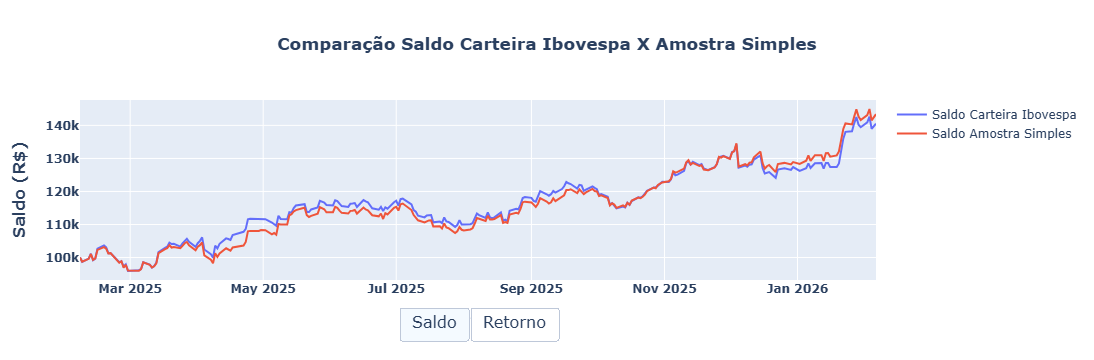

In [32]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_ibov, carteira_ibov_amostra_simples,"simples", "Ibovespa")

### SMALL

In [33]:
# Número de amostras em 50% do total
n_amostras = df_retornos_acumulado_small.shape[1] // 2
print(f"\nSerão escolhidos {n_amostras} ações como amostra.")

# Escolhe n_amostras de ações como amostra
acoes_escolhidas = amostragem_aleatoria_simples(df_retornos_acumulado_small, n_amostras)
print(f"\nAções escolhidas: {acoes_escolhidas}")

# Monta a carteira com as amostras escolhidas
carteira_small_amostra_simples = df_retornos_acumulado_small[acoes_escolhidas]

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/carteira_small_amostra_simples.shape[1],2)
carteira_small_amostra_simples = carteira_small_amostra_simples*valor_por_acao
carteira_small_amostra_simples['saldo'] = carteira_small_amostra_simples.sum(axis=1)
carteira_small_amostra_simples["retorno"] = carteira_small_amostra_simples['saldo'].pct_change()
carteira_small_amostra_simples


Serão escolhidos 54 ações como amostra.

Ações escolhidas: ['HYPE3.SA', 'ANIM3.SA', 'ARML3.SA', 'LJQQ3.SA', 'PRNR3.SA', 'MDIA3.SA', 'SLCE3.SA', 'MRVE3.SA', 'DESK3.SA', 'TEND3.SA', 'UNIP6.SA', 'QUAL3.SA', 'GOAU4.SA', 'PNVL3.SA', 'LEVE3.SA', 'ODPV3.SA', 'KEPL3.SA', 'RANI3.SA', 'CBAV3.SA', 'RCSL4.SA', 'COGN3.SA', 'HAPV3.SA', 'VIVA3.SA', 'BEEF3.SA', 'BRKM5.SA', 'BRBI11.SA', 'HBSA3.SA', 'FESA4.SA', 'PCAR3.SA', 'IGTI11.SA', 'ALUP11.SA', 'PGMN3.SA', 'AZZA3.SA', 'DIRR3.SA', 'ALOS3.SA', 'TAEE11.SA', 'PLPL3.SA', 'ONCO3.SA', 'MULT3.SA', 'BRAV3.SA', 'LAVV3.SA', 'AURE3.SA', 'ABCB4.SA', 'EZTC3.SA', 'BMOB3.SA', 'AMOB3.SA', 'SEER3.SA', 'CSMG3.SA', 'DXCO3.SA', 'JHSF3.SA', 'AGRO3.SA', 'MOVI3.SA', 'SAPR11.SA', 'SOJA3.SA']


Ticker         HYPE3.SA     ANIM3.SA     ARML3.SA     LJQQ3.SA     PRNR3.SA  \
Date                                                                          
2025-02-06  1851.850000  1851.850000  1851.850000  1851.850000  1851.850000   
2025-02-07  1807.990450  1805.085962  1787.250436  1819.218313  1809.407248   
2025-02-10  1828.458397  1945.377622  1817.396875  1892.639609  1806.056376   
2025-02-11  1869.393898  1973.436045  1877.689873  1908.955453  1814.991680   
2025-02-12  1889.861453  1917.319426  1800.170253  1762.112860  1787.068773   
...                 ...          ...          ...          ...          ...   
2026-02-02  2606.184017  4880.139260  2357.681927  2031.324474  2023.224861   
2026-02-03  2628.748310  4613.776689  2422.756007  2088.429927  2111.727050   
2026-02-04  2357.976006  4547.186387  2287.602277  2015.008631  2094.922899   
2026-02-05  2395.925250  4547.186387  2272.585090  1941.587334  2174.462647   
2026-02-06  2425.669082  4632.802555  2382.710493  2039.482396  2166.620724   

Ticker         MDIA3.SA     SLCE3.SA     MRVE3.SA     DESK3.SA     TEND3.SA  \
Date                                                                          
2025-02-06  1851.850000  1851.850000  1851.850000  1851.850000  1851.850000   
2025-02-07  1811.610517  1867.273406  1795.833159  1806.956743  1850.587662   
2025-02-10  1812.449213  1844.652227  1848.554975  1797.603906  1923.803238   
2025-02-11  1876.161361  1876.527498  1878.210829  1814.439013  1952.837000   
2025-02-12  1869.455006  1868.301865  1818.898963  1775.157278  1937.688950   
...                 ...          ...          ...          ...          ...   
2026-02-02  2223.841388  1999.995755  2728.348366  2660.337478  3730.257230   
2026-02-03  2235.359217  2033.872661  2771.184793  2777.483000  3825.904760   
2026-02-04  2207.007482  1981.175265  2695.397486  2749.141408  3748.855297   
2026-02-05  2201.691574  1956.081239  2879.923293  3013.663530  3865.758088   
2026-02-06  2179.541760  1941.024823  2945.825367  3030.668737  3945.464490   

Ticker      ...     SEER3.SA     CSMG3.SA     DXCO3.SA     JHSF3.SA  \
Date        ...                                                       
2025-02-06  ...  1851.850000  1851.850000  1851.850000  1851.850000   
2025-02-07  ...  1791.999258  1870.344179  1839.686550  1818.949165   
2025-02-10  ...  1851.850000  1918.590459  1833.604988  1842.449796   
2025-02-11  ...  1830.726046  1948.342064  1906.584548  1875.350872   
2025-02-12  ...  1753.272297  1909.745338  1854.890618  1842.449796   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  4528.240379  4528.796623  1930.144747  4946.876405   
2026-02-03  ...  4524.626722  4712.092610  1960.836148  5032.865095   
2026-02-04  ...  4293.335784  4623.038488  1902.863575  4795.131630   
2026-02-05  ...  4412.595082  4649.841006  1923.324454  4926.643801   
2026-02-06  ...  4510.170716  4655.893209  1906.273803  4931.702073   

Ticker         AGRO3.SA     MOVI3.SA    SAPR11.SA     SOJA3.SA          saldo  \
Date                                                                            
2025-02-06  1851.850000  1851.850000  1851.850000  1851.850000   99999.900000   
2025-02-07  1793.979753  1777.350163  1850.484227  1842.691607   98536.803264   
2025-02-10  1801.315500  1846.528622  1850.484227  1862.840451   99827.564299   
2025-02-11  1805.390754  1974.242373  1865.506494  1899.474212  101277.764338   
2025-02-12  1788.274334  1979.563750  1853.898385  1886.652462   99437.534909   
...                 ...          ...          ...          ...            ...   
2026-02-02  1798.071315  7297.795424  3349.513695  1753.286106  174521.764652   
2026-02-03  1813.309233  7592.247187  3378.989979  1759.256380  176524.875405   
2026-02-04  1713.416355  7419.040462  3329.383630  1721.444203  173249.833798   
2026-02-05  1698.178437  7488.323262  3350.951596  1691.592644  173625.565928   
2026-02-06  1708.337103  7869.378937  3302.06405

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_simples.html


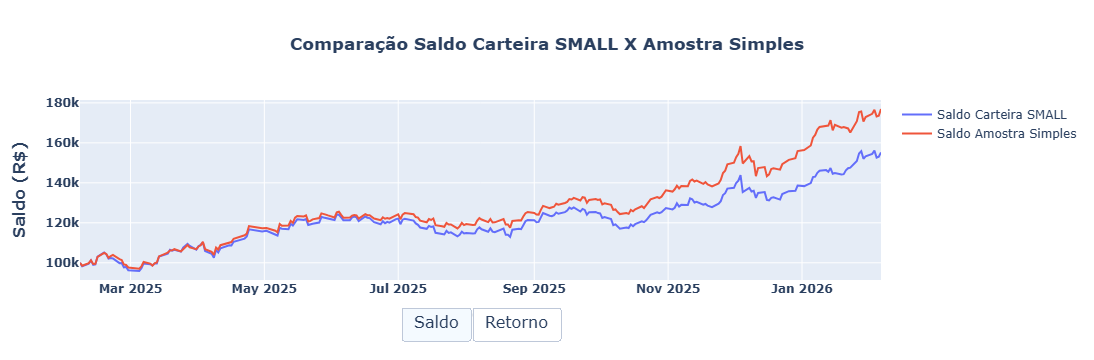

In [34]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_small, carteira_small_amostra_simples,"simples", "SMALL")

### IBrA

In [35]:
# Número de amostras em 50% do total
n_amostras = df_retornos_acumulado_ibra.shape[1] // 2
print(f"\nSerão escolhidos {n_amostras} ações como amostra.")

# Escolhe n_amostras de ações como amostra
acoes_escolhidas = amostragem_aleatoria_simples(df_retornos_acumulado_ibra, n_amostras)
print(f"\nAções escolhidas: {acoes_escolhidas}")

# Monta a carteira com as amostras escolhidas
carteira_ibra_amostra_simples = df_retornos_acumulado_ibra[acoes_escolhidas]

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/carteira_ibra_amostra_simples.shape[1],2)
carteira_ibra_amostra_simples = carteira_ibra_amostra_simples*valor_por_acao
carteira_ibra_amostra_simples['saldo'] = carteira_ibra_amostra_simples.sum(axis=1)
carteira_ibra_amostra_simples["retorno"] = carteira_ibra_amostra_simples['saldo'].pct_change()
carteira_ibra_amostra_simples


Serão escolhidos 76 ações como amostra.

Ações escolhidas: ['CMIG4.SA', 'PLPL3.SA', 'IGTI11.SA', 'MGLU3.SA', 'DIRR3.SA', 'YDUQ3.SA', 'PRIO3.SA', 'MYPK3.SA', 'HAPV3.SA', 'LAVV3.SA', 'LEVE3.SA', 'DXCO3.SA', 'ITUB3.SA', 'POMO4.SA', 'FLRY3.SA', 'USIM5.SA', 'GMAT3.SA', 'IRBR3.SA', 'ABCB4.SA', 'TFCO4.SA', 'SANB11.SA', 'ISAE4.SA', 'AURE3.SA', 'CXSE3.SA', 'PETR4.SA', 'RECV3.SA', 'BPAC11.SA', 'RDOR3.SA', 'TEND3.SA', 'MULT3.SA', 'PETR3.SA', 'WEGE3.SA', 'LREN3.SA', 'BBSE3.SA', 'MILS3.SA', 'PSSA3.SA', 'TAEE11.SA', 'BHIA3.SA', 'HYPE3.SA', 'POSI3.SA', 'ABEV3.SA', 'ODPV3.SA', 'ONCO3.SA', 'RENT3.SA', 'PGMN3.SA', 'SLCE3.SA', 'UNIP6.SA', 'SBFG3.SA', 'CSMG3.SA', 'UGPA3.SA', 'MDIA3.SA', 'MDNE3.SA', 'BRAP4.SA', 'HBOR3.SA', 'CEAB3.SA', 'GGBR4.SA', 'KLBN11.SA', 'QUAL3.SA', 'AZZA3.SA', 'RCSL3.SA', 'BMOB3.SA', 'ALOS3.SA', 'ALUP11.SA', 'ENGI11.SA', 'EQTL3.SA', 'FESA4.SA', 'BBAS3.SA', 'BLAU3.SA', 'BEEF3.SA', 'VULC3.SA', 'ANIM3.SA', 'RADL3.SA', 'GOAU4.SA', 'VLID3.SA', 'DESK3.SA', 'MOVI3.SA']


Ticker         CMIG4.SA     PLPL3.SA    IGTI11.SA     MGLU3.SA     DIRR3.SA  \
Date                                                                          
2025-02-06  1315.790000  1315.790000  1315.790000  1315.790000  1315.790000   
2025-02-07  1316.990361  1278.269900  1325.567675  1258.813999  1302.211594   
2025-02-10  1324.193731  1295.089330  1303.218743  1292.643382  1307.467653   
2025-02-11  1336.199213  1332.609302  1318.583582  1294.423919  1325.864222   
2025-02-12  1326.594854  1326.140399  1298.330043  1262.374798  1329.368116   
...                 ...          ...          ...          ...          ...   
2026-02-02  1623.187810  2037.570089  2067.040328  1893.026521  2262.365248   
2026-02-03  1656.770973  2056.349584  2072.824276  1948.873685  2250.193825   
2026-02-04  1617.590616  2045.618481  2031.613630  1873.768802  2196.943744   
2026-02-05  1613.392621  2042.935641  2067.040328  1858.362701  2250.193825   
2026-02-06  1588.205315  1962.452368  2070.655244  1964.279787  2405.379676   

Ticker         YDUQ3.SA     PRIO3.SA     MYPK3.SA     HAPV3.SA     LAVV3.SA  \
Date                                                                          
2025-02-06  1315.790000  1315.790000  1315.790000  1315.790000  1315.790000   
2025-02-07  1329.720449  1284.979019  1280.960208  1350.568650  1304.145850   
2025-02-10  1377.843709  1297.303436  1274.187828  1356.364993  1317.245648   
2025-02-11  1434.831596  1307.033187  1273.220318  1454.904305  1321.719092   
2025-02-12  1395.573227  1281.411414  1257.740443  1350.568650  1301.900826   
...                 ...          ...          ...          ...          ...   
2026-02-02  2000.296458  1650.170005  1098.293306   492.310269  3026.670395   
2026-02-03  1932.653613  1670.278174  1085.170304   494.628858  3103.049193   
2026-02-04  1845.684185  1629.737441  1082.141949   481.490274  3030.884986   
2026-02-05  1867.771633  1594.061646  1058.924302   465.646699  3121.089901   
2026-02-06  1863.630270  1642.061859  1059.933786   454.826703  3126.502320   

Ticker      ...     BEEF3.SA     VULC3.SA     ANIM3.SA     RADL3.SA  \
Date        ...                                                       
2025-02-06  ...  1315.790000  1315.790000  1315.790000  1315.790000   
2025-02-07  ...  1253.671178  1304.041678  1282.562874  1323.684595   
2025-02-10  ...  1264.965497  1306.391188  1382.243930  1300.658420   
2025-02-11  ...  1287.554272  1332.237342  1402.180205  1314.474256   
2025-02-12  ...  1233.906085  1311.090690  1362.307815  1291.448081   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  1802.721547  1829.756269  3467.472223  1730.408762   
2026-02-03  ...  1828.847990  1830.768885  3278.214343  1834.095835   
2026-02-04  ...  1753.371660  1816.592639  3230.900114  1757.188855   
2026-02-05  ...  1767.886381  1784.189681  3230.900114  1803.882444   
2026-02-06  ...  1782.400964  1761.912502  3291.732740  1829.975851   

Ticker         GOAU4.SA     VLID3.SA     DESK3.SA     MOVI3.SA          saldo  \
Date                                                                            
2025-02-06  1315.790000  1315.790000  1315.790000  1315.790000  100000.040000   
2025-02-07  1286.886708  1360.180812  1283.891990  1262.855929   98644.010239   
2025-02-10  1348.822307  1396.035025  1277.246673  1312.009016   99635.841693   
2025-02-11  1355.704061  1393.189368  1289.208346  1402.753123  100939.291941   
2025-02-12  1318.542738  1363.026469  1261.297604  1406.534205   98910.492324   
...                 ...          ...          ...          ...            ...   
2026-02-02  1912.066005  1437.587373  1890.242250  5185.282956  144762.610920   
2026-02-03  1965.603802  1441.488525  1973.477334  5394.498974  146408.653650   
2026-02-04  1919.714261  1402.476632  1953.339861  5271.430866  142833.401723   
2026-02-05  1883.385087  1388.822538  2141.290034  5320.658188  143264.521997   
2026-02-06  1889.121234  1416.781063  2153.37269

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_simples.html


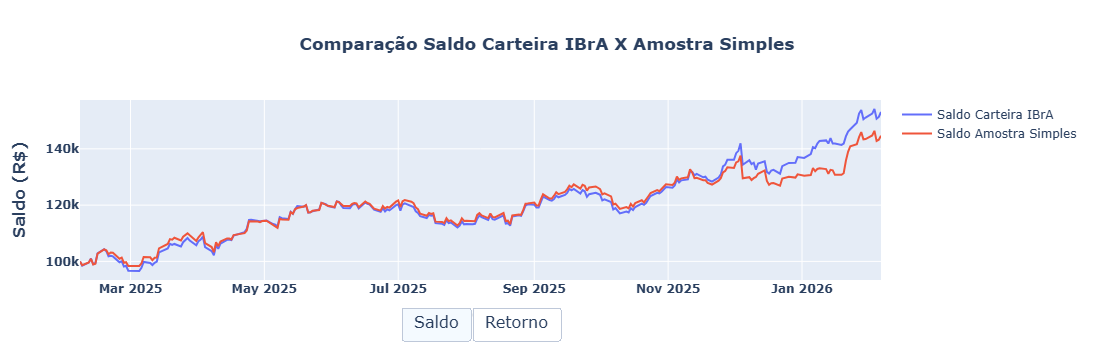

In [36]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_ibra, carteira_ibra_amostra_simples,"simples", "IBrA")

### Juntando todos as comparações de índice

In [37]:
def html_amostragem_todos_indices(amostragem):
    # Lista dos HTML's gerados anteriormente
    arquivos_html = [
        f'html_indice_ibovespa_x_amostra_{amostragem.lower()}.html',
        f'html_indice_small_x_amostra_{amostragem.lower()}.html',
        f'html_indice_ibra_x_amostra_{amostragem.lower()}.html'
    ]
    
    # Nome das abas
    nomes_abas = [
        "Ibovespa",
        "SMALL",
        "IBrA"
    ]

    # HTML consolidado
    html_final = """
    <!DOCTYPE html>
    <html lang="pt-br">
    <head>
    <meta charset="UTF-8">
    
    <style>
    html, body {
        width: 100%;
        height: 100%;
        margin: 0;
    }
    
    body {
        display: grid;
        grid-template-columns: 220px 1fr;
        font-family: Arial;
        background: #f8f9fa;
    }
    
    .tabs {
        background: transparent;
        display: flex;
        flex-direction: column;
        justify-content: center;
        padding: 12px;
    }
    
    .tab-button {
        width: 100%;
        background: #4C72B0;
        color: white;
        border: 1px solid #000;
        padding: 10px;
        margin-bottom: 8px;
        cursor: pointer;
        border-radius: 6px;
    }
    
    .tab-button.active {
        background: #2A4A7C;
        font-weight: bold;
    }
    
    .tab-container {
        position: relative;
        height: 100vh;
        overflow: hidden;
    }
    
    .tab-content {
        position: absolute;
        inset: 0;
        opacity: 0;
        pointer-events: none;
        transition: opacity 0.15s ease;
    }
    
    .tab-content.active {
        opacity: 1;
        pointer-events: auto;
        z-index: 1;
    }
    
    iframe {
        width: 100%;
        height: 100%;
        border: none;
    }
    </style>
    </head>
    
    <body>
    
    <div class="tabs">
    """

    # Adiciona os botões
    for i, nome in enumerate(nomes_abas):
        active = "active" if i == 0 else ""
        html_final += f"""
        <button class="tab-button {active}" onclick="openTab({i})">{nome}</button>
        """
    
    html_final += """
    </div>
    
    <div class="tab-container">
    """

    # Adiciona os gráficos
    for i, arquivo in enumerate(arquivos_html):
        active = "active" if i == 0 else ""
        html_final += f"""
        <div class="tab-content {active}">
            <iframe src="{arquivo}"></iframe>
        </div>
        """

    # JS
    html_final += """
    </div>
    
    <script>
    function openTab(index) {
        const tabs = document.querySelectorAll('.tab-content');
        const buttons = document.querySelectorAll('.tab-button');
    
        tabs.forEach((t, i) => {
            t.classList.toggle('active', i === index);
        });
    
        buttons.forEach((b, i) => {
            b.classList.toggle('active', i === index);
        });
    }
    </script>
    
    </body>
    </html>
    """

    return html_final    

In [38]:
# Salvar e abrir
html_todos_indices_amostragem_simples = html_amostragem_todos_indices("simples")
saida = Path("resultados/comparacoes_todos_indices_x_amostragem_simples.html")
saida.write_text(html_todos_indices_amostragem_simples, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

2481

## Amostragem sistemática

In [39]:
# Função para amostragem sistemática de ações (colunas)
def amostragem_sistematica(dataset, amostras):
    n_colunas = dataset.shape[1]
    intervalo = n_colunas // amostras

    random.seed(seed)
    inicio = random.randint(0, intervalo - 1)

    indices = np.arange(inicio, n_colunas, step=intervalo)[:amostras]

    colunas_selecionadas = dataset.columns[indices].tolist()
    return colunas_selecionadas

### Ibovespa

In [40]:
# Número de amostras em 50% do total
n_amostras = df_retornos_acumulado_ibov.shape[1] // 2
print(f"\nSerão escolhidos {n_amostras} ações como amostra.")

# Escolhe n_amostras de ações como amostra
acoes_escolhidas = amostragem_sistematica(df_retornos_acumulado_ibov, n_amostras)
print(f"\nAções escolhidas: {acoes_escolhidas}")

# Monta a carteira com as amostras escolhidas
carteira_ibov_amostra_sistematica = df_retornos_acumulado_ibov[acoes_escolhidas]

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/carteira_ibov_amostra_sistematica.shape[1],2)
carteira_ibov_amostra_sistematica = carteira_ibov_amostra_sistematica*valor_por_acao
carteira_ibov_amostra_sistematica['saldo'] = carteira_ibov_amostra_sistematica.sum(axis=1)
carteira_ibov_amostra_sistematica["retorno"] = carteira_ibov_amostra_sistematica['saldo'].pct_change()
carteira_ibov_amostra_sistematica


Serão escolhidos 39 ações como amostra.

Ações escolhidas: ['VALE3.SA', 'PETR4.SA', 'AXIA3.SA', 'SBSP3.SA', 'ITSA4.SA', 'WEGE3.SA', 'ABEV3.SA', 'RENT3.SA', 'ENEV3.SA', 'VBBR3.SA', 'SUZB3.SA', 'UGPA3.SA', 'BBDC3.SA', 'CPLE3.SA', 'TIMS3.SA', 'RAIL3.SA', 'AXIA6.SA', 'LREN3.SA', 'MBRF3.SA', 'EGIE3.SA', 'ISAE4.SA', 'MULT3.SA', 'SMFT3.SA', 'CMIN3.SA', 'CPFE3.SA', 'GOAU4.SA', 'CYRE3.SA', 'FLRY3.SA', 'CSNA3.SA', 'BRAP4.SA', 'DIRR3.SA', 'POMO4.SA', 'AURE3.SA', 'YDUQ3.SA', 'HAPV3.SA', 'AZZA3.SA', 'RECV3.SA', 'CEAB3.SA', 'VAMO3.SA']


Ticker         VALE3.SA     PETR4.SA     AXIA3.SA     SBSP3.SA     ITSA4.SA  \
Date                                                                          
2025-02-06  2564.100000  2564.100000  2564.100000  2564.100000  2564.100000   
2025-02-07  2550.146892  2549.463583  2509.928816  2531.055494  2537.445888   
2025-02-10  2576.657717  2566.887988  2555.432828  2548.102423  2550.773174   
2025-02-11  2565.495190  2566.887988  2604.547709  2571.443296  2585.422952   
2025-02-12  2548.286638  2528.555008  2590.824233  2545.479802  2518.788209   
...                 ...          ...          ...          ...          ...   
2026-02-02  4464.901051  2889.586234  4401.903186  4084.956499  4455.897476   
2026-02-03  4684.408588  2915.968074  4492.158292  4141.589398  4504.121660   
2026-02-04  4707.570194  2911.312351  4352.817298  4084.672069  4365.879429   
2026-02-05  4550.703651  2870.963637  4504.825627  4126.506340  4449.467769   
2026-02-06  4507.539096  2843.805991  4562.620365  4093.779050  4558.775551   

Ticker         WEGE3.SA     ABEV3.SA     RENT3.SA     ENEV3.SA     VBBR3.SA  \
Date                                                                          
2025-02-06  2564.100000  2564.100000  2564.100000  2564.100000  2564.100000   
2025-02-07  2536.357503  2561.739031  2407.311263  2508.124635  2581.329605   
2025-02-10  2549.053334  2590.071388  2430.628535  2542.571156  2659.646525   
2025-02-11  2497.329298  2587.710419  2494.952144  2602.852207  2722.300199   
2025-02-12  2478.050373  2578.266300  2466.810626  2546.876842  2706.636780   
...                 ...          ...          ...          ...          ...   
2026-02-02  2576.624603  3821.976022  4192.233591  4521.083181  5365.530962   
2026-02-03  2678.300799  3903.186589  4283.571497  4557.682443  5461.537875   
2026-02-04  2549.345651  3882.883947  4233.674009  4480.178028  5396.325717   
2026-02-05  2589.520042  3928.564769  4234.519587  4645.951177  5595.585531   
2026-02-06  2571.664673  3913.337909  4313.171565  4712.690861  5753.182300   

Ticker      ...     POMO4.SA     AURE3.SA     YDUQ3.SA     HAPV3.SA  \
Date        ...                                                       
2025-02-06  ...  2564.100000  2564.100000  2564.100000  2564.100000   
2025-02-07  ...  2545.129875  2511.645488  2591.246218  2631.873685   
2025-02-10  ...  2554.614938  2490.046397  2685.024481  2643.169107   
2025-02-11  ...  2586.231681  2579.527710  2796.078147  2835.194164   
2025-02-12  ...  2513.513527  2530.158741  2719.574517  2631.873685   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  2718.643910  3466.527159  3898.007763   959.372515   
2026-02-03  ...  2689.678075  3469.633437  3766.191135   963.890785   
2026-02-04  ...  2573.814933  3404.403075  3596.712503   938.287425   
2026-02-05  ...  2582.090857  3401.296796  3639.754646   907.412810   
2026-02-06  ...  2627.608542  3541.076060  3631.684309   886.327720   

Ticker         AZZA3.SA     RECV3.SA     CEAB3.SA     VAMO3.SA          saldo  \
Date                                                                            
2025-02-06  2564.100000  2564.100000  2564.100000  2564.100000   99999.900000   
2025-02-07  2522.395269  2508.642197  2550.882953  2437.996579   98654.779638   
2025-02-10  2480.690693  2580.410968  2585.247065  2570.104811   99741.435409   
2025-02-11  2435.262113  2621.188572  2609.037907  2732.237695  101369.031928   
2025-02-12  2344.405109  2544.526583  2476.867701  2798.291512   99307.388755   
...                 ...          ...          ...          ...            ...   
2026-02-02  2146.532587  2092.297559  3436.614109  2552.847373  140267.368231   
2026-02-03  2164.563732  2134.373065  3450.415825  2741.017753  142625.478165   
2026-02-04  2085.882202  2069.347332  3442.134901  2596.753645  139827.571223   
2026-02-05  2025.231661  2042.572159  3494.581105  2759.834941  140957.053744   
2026-02-06  2034.247311  2057.872310  3599.47377

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_sistematica.html


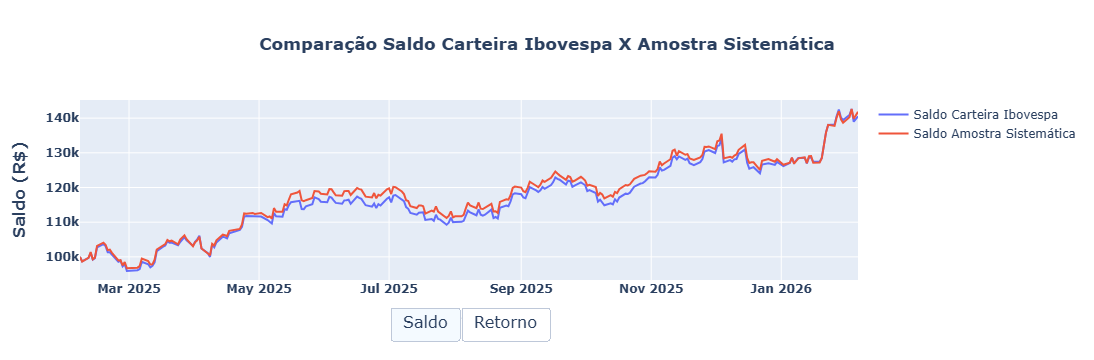

In [41]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_ibov, carteira_ibov_amostra_sistematica,"sistemática", "Ibovespa")

### SMALL

In [42]:
# Número de amostras em 50% do total
n_amostras = df_retornos_acumulado_small.shape[1] // 2
print(f"\nSerão escolhidos {n_amostras} ações como amostra.")

# Escolhe n_amostras de ações como amostra
acoes_escolhidas = amostragem_sistematica(df_retornos_acumulado_small, n_amostras)
print(f"\nAções escolhidas: {acoes_escolhidas}")

# Monta a carteira com as amostras escolhidas
carteira_small_amostra_sistematica = df_retornos_acumulado_small[acoes_escolhidas]

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/carteira_small_amostra_sistematica.shape[1],2)
carteira_small_amostra_sistematica = carteira_small_amostra_sistematica*valor_por_acao
carteira_small_amostra_sistematica['saldo'] = carteira_small_amostra_sistematica.sum(axis=1)
carteira_small_amostra_sistematica["retorno"] = carteira_small_amostra_sistematica['saldo'].pct_change()
carteira_small_amostra_sistematica


Serão escolhidos 54 ações como amostra.

Ações escolhidas: ['LREN3.SA', 'ASAI3.SA', 'CSAN3.SA', 'CSMG3.SA', 'TAEE11.SA', 'BRAV3.SA', 'CYRE3.SA', 'FLRY3.SA', 'CSNA3.SA', 'BRAP4.SA', 'ALUP11.SA', 'IRBR3.SA', 'ORVR3.SA', 'AURE3.SA', 'VIVA3.SA', 'YDUQ3.SA', 'TEND3.SA', 'MRVE3.SA', 'USIM5.SA', 'ODPV3.SA', 'BEEF3.SA', 'CEAB3.SA', 'FRAS3.SA', 'HBSA3.SA', 'ABCB4.SA', 'CBAV3.SA', 'MDNE3.SA', 'SMTO3.SA', 'BMOB3.SA', 'TTEN3.SA', 'VAMO3.SA', 'LWSA3.SA', 'VLID3.SA', 'PCAR3.SA', 'TUPY3.SA', 'PGMN3.SA', 'EVEN3.SA', 'INTB3.SA', 'AGRO3.SA', 'ANIM3.SA', 'FESA4.SA', 'RAPT4.SA', 'PNVL3.SA', 'BRBI11.SA', 'TFCO4.SA', 'PLPL3.SA', 'SEER3.SA', 'DESK3.SA', 'LJQQ3.SA', 'BLAU3.SA', 'POSI3.SA', 'BHIA3.SA', 'AMOB3.SA', 'GFSA3.SA']


Ticker         LREN3.SA     ASAI3.SA     CSAN3.SA     CSMG3.SA    TAEE11.SA  \
Date                                                                          
2025-02-06  1851.850000  1851.850000  1851.850000  1851.850000  1851.850000   
2025-02-07  1783.726561  1873.074802  1738.076146  1870.344179  1840.687519   
2025-02-10  1822.654020  1857.156265  1803.435552  1918.590459  1835.664502   
2025-02-11  1843.508271  1891.646214  1827.642834  1948.342064  1854.640475   
2025-02-12  1768.433415  1891.646214  1769.545520  1909.745338  1825.060302   
...                 ...          ...          ...          ...          ...   
2026-02-02  2212.646340  2334.724058  1408.858455  4528.796623  2573.299843   
2026-02-03  2292.036966  2383.195919  1450.010580  4712.092610  2579.996426   
2026-02-04  2234.699237  2313.181065  1408.858455  4623.038488  2525.206415   
2026-02-05  2234.699237  2342.802616  1365.285441  4649.841006  2538.599580   
2026-02-06  2278.805172  2364.345608  1396.754815  4655.893209  2527.032671   

Ticker         BRAV3.SA     CYRE3.SA     FLRY3.SA     CSNA3.SA     BRAP4.SA  \
Date                                                                          
2025-02-06  1851.850000  1851.850000  1851.850000  1851.850000  1851.850000   
2025-02-07  1833.305087  1805.994535  1885.725358  1827.322015  1843.047608   
2025-02-10  1832.421972  1819.221835  1917.987686  1853.893836  1847.448991   
2025-02-11  1883.641471  1865.077300  2014.774323  1813.014186  1852.950470   
2025-02-12  1843.902132  1844.795123  1932.505473  1712.858995  1828.743362   
...                 ...          ...          ...          ...          ...   
2026-02-02  1625.777746  3057.451339  3069.124730  2046.028484  3135.443320   
2026-02-03  1611.648241  3194.203249  3083.678952  2119.611854  3286.863541   
2026-02-04  1593.986275  3045.473183  2998.172592  2090.996002  3301.222437   
2026-02-05  1553.363989  3104.366321  3063.666766  2023.544530  3192.878405   
2026-02-06  1543.649891  3107.360764  3080.040310  1943.829261  3162.855486   

Ticker      ...     SEER3.SA     DESK3.SA     LJQQ3.SA     BLAU3.SA  \
Date        ...                                                       
2025-02-06  ...  1851.850000  1851.850000  1851.850000  1851.850000   
2025-02-07  ...  1791.999258  1806.956743  1819.218313  1805.403910   
2025-02-10  ...  1851.850000  1797.603906  1892.639609  1793.417699   
2025-02-11  ...  1830.726046  1814.439013  1908.955453  1812.895267   
2025-02-12  ...  1753.272297  1775.157278  1762.112860  1772.442181   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  4528.240379  2660.337478  2031.324474  2149.354006   
2026-02-03  ...  4524.626722  2777.483000  2088.429927  2199.926994   
2026-02-04  ...  4293.335784  2749.141408  2015.008631  2168.318927   
2026-02-05  ...  4412.595082  3013.663530  1941.587334  2170.426185   
2026-02-06  ...  4510.170716  3030.668737  2039.482396  2071.387266   

Ticker         POSI3.SA     BHIA3.SA     AMOB3.SA     GFSA3.SA          saldo  \
Date                                                                            
2025-02-06  1851.850000  1851.850000  1851.850000  1851.850000   99999.900000   
2025-02-07  1808.551541  1800.090267  1714.675926  1795.304883   98372.266888   
2025-02-10  1845.188752  1794.339049  1989.024074  1809.441196  100003.153357   
2025-02-11  1848.519550  1748.330397  1920.437037  1823.577374  101495.798089   
2025-02-12  1791.898248  1679.317420  1851.850000  1625.669800   98899.860685   
...                 ...          ...          ...          ...            ...   
2026-02-02  1662.620458  1794.339049  1838.132540   286.259261  139766.390822   
2026-02-03  1717.192104  1834.596756  1920.437037   282.725183  141452.400342   
2026-02-04  1582.581742  1748.330397  1836.760899   276.363872  137484.441088   
2026-02-05  1578.943713  1713.823909  1824.415211   256.573111  137959.073951   
2026-02-06  1571.667482  1679.317420  1838.13254

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_sistematica.html


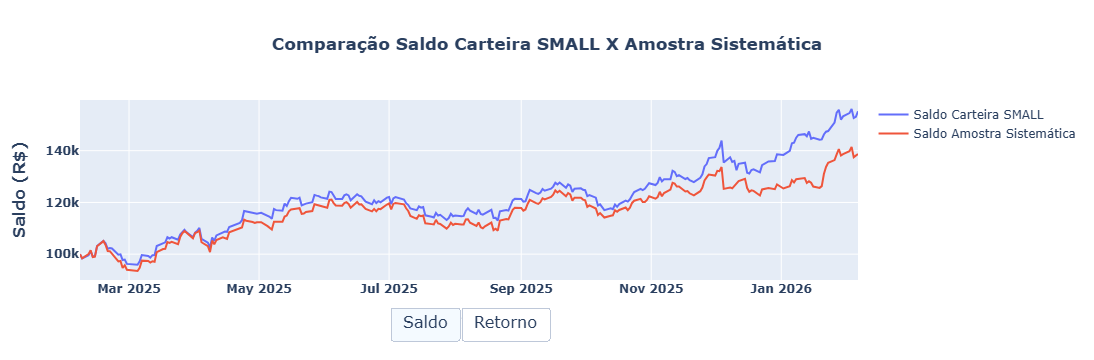

In [43]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_small, carteira_small_amostra_sistematica,"sistemática", "SMALL")

### IBrA

In [44]:
# Número de amostras em 50% do total
n_amostras = df_retornos_acumulado_ibra.shape[1] // 2
print(f"\nSerão escolhidos {n_amostras} ações como amostra.")

# Escolhe n_amostras de ações como amostra
acoes_escolhidas = amostragem_sistematica(df_retornos_acumulado_ibra, n_amostras)
print(f"\nAções escolhidas: {acoes_escolhidas}")

# Monta a carteira com as amostras escolhidas
carteira_ibra_amostra_sistematica = df_retornos_acumulado_ibra[acoes_escolhidas]

# Considerando um investimento de 100000 reais igualmente divido entre as ações
# OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
valor_por_acao = np.round(100000/carteira_ibra_amostra_sistematica.shape[1],2)
carteira_ibra_amostra_sistematica = carteira_ibra_amostra_sistematica*valor_por_acao
carteira_ibra_amostra_sistematica['saldo'] = carteira_ibra_amostra_sistematica.sum(axis=1)
carteira_ibra_amostra_sistematica["retorno"] = carteira_ibra_amostra_sistematica['saldo'].pct_change()
carteira_ibra_amostra_sistematica


Serão escolhidos 76 ações como amostra.

Ações escolhidas: ['VALE3.SA', 'PETR4.SA', 'AXIA3.SA', 'SBSP3.SA', 'BPAC11.SA', 'WEGE3.SA', 'ABEV3.SA', 'RENT3.SA', 'ENEV3.SA', 'PRIO3.SA', 'RADL3.SA', 'VIVT3.SA', 'GGBR4.SA', 'BBSE3.SA', 'TIMS3.SA', 'ITUB3.SA', 'ENGI11.SA', 'KLBN11.SA', 'ALOS3.SA', 'SANB11.SA', 'ASAI3.SA', 'CXSE3.SA', 'CSAN3.SA', 'CSMG3.SA', 'PSSA3.SA', 'SAPR11.SA', 'GOAU4.SA', 'GGPS3.SA', 'HYPE3.SA', 'COGN3.SA', 'NEOE3.SA', 'BRAP4.SA', 'ALUP11.SA', 'IRBR3.SA', 'ORVR3.SA', 'AURE3.SA', 'ECOR3.SA', 'YDUQ3.SA', 'TEND3.SA', 'MRVE3.SA', 'USIM5.SA', 'ODPV3.SA', 'BEEF3.SA', 'CEAB3.SA', 'FRAS3.SA', 'HBSA3.SA', 'ABCB4.SA', 'CBAV3.SA', 'EZTC3.SA', 'SMTO3.SA', 'DXCO3.SA', 'TTEN3.SA', 'VAMO3.SA', 'MOVI3.SA', 'VLID3.SA', 'PCAR3.SA', 'TUPY3.SA', 'PGMN3.SA', 'EVEN3.SA', 'INTB3.SA', 'AGRO3.SA', 'TGMA3.SA', 'FESA4.SA', 'CVCB3.SA', 'PNVL3.SA', 'BRBI11.SA', 'TFCO4.SA', 'PLPL3.SA', 'CAML3.SA', 'DESK3.SA', 'LJQQ3.SA', 'BLAU3.SA', 'CASH3.SA', 'BHIA3.SA', 'RCSL4.SA', 'GFSA3.SA']


Ticker         VALE3.SA     PETR4.SA     AXIA3.SA     SBSP3.SA    BPAC11.SA  \
Date                                                                          
2025-02-06  1315.790000  1315.790000  1315.790000  1315.790000  1315.790000   
2025-02-07  1308.629842  1308.279348  1287.991439  1298.832927  1316.609847   
2025-02-10  1322.234101  1317.220376  1311.342057  1307.580706  1293.245361   
2025-02-11  1316.505954  1317.220376  1336.545933  1319.558276  1324.808000   
2025-02-12  1307.675237  1297.549933  1329.503614  1306.234885  1299.803739   
...                 ...          ...          ...          ...          ...   
2026-02-02  2291.202431  1482.816065  2258.874268  2096.230612  2574.383654   
2026-02-03  2403.844615  1496.354133  2305.189448  2125.292272  2578.595765   
2026-02-04  2415.730192  1493.965008  2233.685425  2096.084654  2451.392886   
2026-02-05  2335.232774  1473.259718  2311.689799  2117.552271  2484.246554   
2026-02-06  2313.082511  1459.323539  2341.347663  2100.757980  2538.581589   

Ticker         WEGE3.SA     ABEV3.SA     RENT3.SA     ENEV3.SA     PRIO3.SA  \
Date                                                                          
2025-02-06  1315.790000  1315.790000  1315.790000  1315.790000  1315.790000   
2025-02-07  1301.553409  1314.578448  1235.332587  1287.065759  1284.979019   
2025-02-10  1308.068577  1329.117566  1247.298047  1304.742288  1297.303436   
2025-02-11  1281.525945  1327.905890  1280.306346  1335.676029  1307.033187   
2025-02-12  1271.632702  1323.059559  1265.865282  1306.951788  1281.411414   
...                 ...          ...          ...          ...          ...   
2026-02-02  1322.217010  1961.279915  2151.280911  2320.032775  1650.170005   
2026-02-03  1374.393022  2002.953817  2198.151747  2338.814001  1670.278174   
2026-02-04  1308.218582  1992.535341  2172.546420  2299.041944  1629.737441   
2026-02-05  1328.834416  2015.976849  2172.980335  2384.109863  1594.061646   
2026-02-06  1319.671780  2008.163054  2213.341278  2418.357906  1642.061859   

Ticker      ...     CAML3.SA     DESK3.SA     LJQQ3.SA     BLAU3.SA  \
Date        ...                                                       
2025-02-06  ...  1315.790000  1315.790000  1315.790000  1315.790000   
2025-02-07  ...  1280.780334  1283.891990  1292.604295  1282.788642   
2025-02-10  ...  1312.872528  1277.246673  1344.772131  1274.272254   
2025-02-11  ...  1301.202935  1289.208346  1356.364984  1288.111312   
2025-02-12  ...  1274.945094  1261.297604  1252.029311  1259.368576   
...         ...          ...          ...          ...          ...   
2026-02-02  ...  2105.403279  1890.242250  1443.311515  1527.174721   
2026-02-03  ...  2148.813615  1973.477334  1483.886499  1563.108210   
2026-02-04  ...  2120.907045  1953.339861  1431.718663  1540.649815   
2026-02-05  ...  2096.101138  2141.290034  1379.550827  1542.147080   
2026-02-06  ...  2086.798850  2153.372697  1449.107942  1471.777223   

Ticker         CASH3.SA     BHIA3.SA      RCSL4.SA     GFSA3.SA  \
Date                                                              
2025-02-06  1315.790000  1315.790000   1315.790000  1315.790000   
2025-02-07  1292.173021  1279.013296   1315.790000  1275.613150   
2025-02-10  1315.790000  1274.926898   1315.790000  1285.657386   
2025-02-11  1295.546956  1242.236495   1335.726192  1295.701527   
2025-02-12  1282.051784  1193.200890   1594.896930  1155.082791   
...                 ...          ...           ...          ...   
2026-02-02  1287.011943  1274.926898  14812.604675   203.395023   
2026-02-03  1273.320339  1303.531099  15051.839934   200.883964   
2026-02-04  1221.976745  1242.236495  15689.798088   196.364079   
2026-02-05  1153.518646  1217.718693  15370.819011   182.302203   
2026-02-06  1204.862241  1193.200890  17085.332501   183.808831   

Ticker              saldo   retorno  
Date                                 
2025-02-06  100000.040000       NaN  
2025-02-07   98584.028969 -0.01416

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_sistematica.html


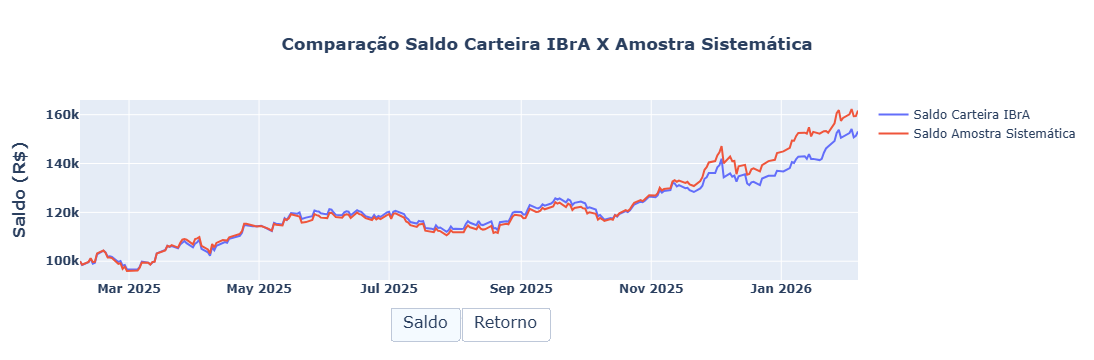

In [45]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_ibra, carteira_ibra_amostra_sistematica,"sistemática", "IBrA")

### Juntando todos as comparações de índice 

In [46]:
# Salvar e abrir
html_todos_indices_amostragem_sistemática = html_amostragem_todos_indices("sistematica")
saida = Path("resultados/comparacoes_todos_indices_x_amostragem_sistematica.html")
saida.write_text(html_todos_indices_amostragem_sistemática, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

2493

## Amostragem por grupos

Serão realizados dois tipos de agrupamento:
- Por Setor. Como a tabela da B3 já contém os setores, iremos usá-los para separar as ações em grupos por setor.
- Por grupos que serão agrupados por porcentagem de participação no índice. Por exemplo, se forem feitos n grupos com mesmo número de ações cada, as ações com mais participação no índice ficarão no grupo 1 e as ações com menos participação ficarão no grupo n.

A idéia da amostragem por grupo é dividir os dados em grupos e escolher aleatoriamente um dos grupos, porém, iremos plotar todos os grupos para comparar com o índice.

### Setor

In [47]:
def amostragem_agrupamento(dataset, dataset_retornos_acumulados, amostragem): 
    if amostragem == 'setor':
        sort_value = True
    else:
        sort_value = False
    
    df_grupos = (
    dataset
    .assign(Código=dataset["Código"].astype(str).str.strip().str.upper() + ".SA")
    .loc[
        lambda x: 
            x["Código"].isin(dataset_retornos_acumulados.columns)
    ]
    )
    
    listas_por_grupo = (
        df_grupos
        .groupby(amostragem.title(), sort = sort_value)["Código"]
        .apply(list)
        .to_dict()
    )

    resultados = {}
    
    for grupo, acoes_escolhidas in listas_por_grupo.items():
    
        print(f"\n===== Grupo: {grupo} =====")
    
        # Número de amostras (50% das ações do grupo)
        n_amostras = len(acoes_escolhidas)
        print(f"Serão escolhidas {n_amostras} ações")
    
        if n_amostras == 0:
            print("Grupo com poucas ações — pulando")
            continue
    
        # Amostragem agrupada por grupo
        print(f"Ações escolhidas: {acoes_escolhidas}")
    
        # Monta carteira da amostra 
        carteira_amostra = dataset_retornos_acumulados[acoes_escolhidas]
    
        # Investimento igualitário de 100000
        valor_por_acao = np.round(100000 / carteira_amostra.shape[1], 2)
        carteira_amostra = carteira_amostra * valor_por_acao
    
        # Métricas
        carteira_amostra["saldo"] = carteira_amostra.sum(axis=1)
        carteira_amostra["retorno"] = carteira_amostra["saldo"].pct_change()
    
        # Guarda resultados
        resultados[grupo] = {
            "acoes_escolhidas": acoes_escolhidas,
            "carteira_amostra": carteira_amostra
        }

    return resultados

In [48]:
def plot_amostragem_por_grupo(resultados, carteira_indice, valor, amostragem, indice):
    fig = go.Figure()

    grupos = list(resultados.keys())
    n_grupos = len(grupos)

    if amostragem == "setor":
        label_text = "setores"
    else:
        label_text = "grupos"

    if valor == "saldo":
        texto_hover = "<b>%{fullData.name}</b><br><b>Data:</b> <b>%{x}</b><br><b>Saldo:</b> <b>R$ %{y}</b><extra></extra>"
        ylabel_text = "Saldo (R$)"
    else:
        texto_hover = "<b>%{fullData.name}</b><br><b>Data:</b> <b>%{x}</b><br><b>Retorno:</b> <b>%{y:.2%}</b><extra></extra>"
        ylabel_text = "Retorno"
    
    # Grupos (começam desligados)
    for grupo, res in resultados.items():
        fig.add_trace(
            go.Scatter(
                x=res["carteira_amostra"].index,
                y=res["carteira_amostra"][valor],
                mode="lines",
                name=grupo,
                visible="legendonly",
                line=dict(width=1.5),
                hovertemplate=texto_hover
            )
        )
    
    # Índice (começa visível)
    fig.add_trace(
        go.Scatter(
            x=carteira_indice.index,
            y=carteira_indice[valor],
            mode="lines",
            name= f"{indice}",
            line=dict(color="black", width=4),
            hovertemplate=texto_hover
        )
    )
    
    # Botões globais
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                x=0.5,
                y=0.95,
                xanchor="center",
                yanchor="bottom",
                font=dict(size=14),
                buttons=[
                    dict(
                        label=f"Mostrar todos os {label_text}",
                        method="update",
                        args=[{"visible": [True]*n_grupos + [True]}]
                    ),
                    dict(
                        label=f"Ocultar todos os {label_text}",
                        method="update",
                        args=[{"visible": ["legendonly"]*n_grupos + [True]}]
                    )
                ]
            )
        ],
        title=dict(
        text=f"<b>Comparação {valor.title()} Carteira {indice} X Amostra {amostragem.title()}</b>",
        xanchor='center',    
        x=0.5,
        ),
        xaxis=dict(
        title=dict(text = "Data",
                   font=dict(size = 16,
                            weight = 1000)),
        tickfont=dict(size=12, weight = 1000) 
         ),
         yaxis=dict(
            title=dict(text = ylabel_text,
                       font=dict(size = 16,
                                weight = 1000)),
            tickfont=dict(size=12, weight = 1000) 
         ),
        legend=dict(x=1.02,
                    y=0.5,
                    font=dict(weight=1000),
                    title=dict(text="Setor"))
    )
    
    # Nome do HTML
    nome_html = unidecode(f"html_indice_{indice.lower()}_x_amostra_{amostragem.lower()}_{valor}.html")
   
    # Pasta onde salvar os resultados
    pasta_resultados = "resultados"

    # Cria a pasta se não existir
    os.makedirs(pasta_resultados, exist_ok=True)

    # Nome completo do HTML
    nome_html_completo =os.path.join(os.getcwd(), pasta_resultados, nome_html)

    # Salva o HTML 
    fig.write_html(nome_html_completo)
    print(f"HTML interativo criado: {nome_html_completo}")

    # Mostra o HTML
    fig.show()

# Função para juntar os gráficos de saldo e retorno
def plot_amostragem_por_grupo_completo(resultados, carteira_indice, amostragem, indice):

    # Gerando os gráficos para saldo e retorno
    plot_amostragem_por_grupo(resultados, carteira_indice, "saldo", amostragem, indice)
    plot_amostragem_por_grupo(resultados, carteira_indice, "retorno", amostragem, indice)
    
    arquivos_html = [
        f'resultados/html_indice_{indice.lower()}_x_amostra_{amostragem.lower()}_saldo.html',
        f'resultados/html_indice_{indice.lower()}_x_amostra_{amostragem.lower()}_retorno.html',
    ]
    
    nomes_abas = ["Saldo", "Retorno"]
    
    def extrair_plotly(html_texto):
        html_texto = re.sub(r"<\/?(html|head|body).*?>", "", html_texto, flags=re.I|re.S)
        html_texto = re.sub(
            r"<script[^>]*plotly[^>]*>.*?<\/script>",
            "",
            html_texto,
            flags=re.I|re.S
        )
        return html_texto.strip()
    
    conteudos = []
    for arquivo in arquivos_html:
        texto = Path(arquivo).read_text(encoding="utf-8")
        conteudos.append(extrair_plotly(texto))

    # HTML consolidado
    html_final = f"""
    <!DOCTYPE html>
    <html lang="pt-br">
    <head>
    <meta charset="UTF-8">
    <script src="https://cdn.plot.ly/plotly-2.30.0.min.js"></script>
    
    <style>
    html, body {{
        width: 100%;
        height: 100%;
        margin: 0;
        padding: 0;
    }}
    
    body {{
        display: flex;
        flex-direction: column;
        font-family: Arial;
        background: #f8f9fa;
    }}
    
    .tab-container {{
        flex: 1;
        position: relative;
        overflow: hidden;
    }}
    
    .tab-content {{
        position: absolute;
        inset: 0;
        visibility: hidden;
        opacity: 0;
        pointer-events: none;
    }}
    
    .tab-content.active {{
        visibility: visible;
        opacity: 1;
        pointer-events: auto;
    }}
    
    .tab-content > div {{
        width: 100%;
        height: calc(100% - 50px); 
    }}
    
    .tabs {{
        display: flex;
        justify-content: center;
        flex-wrap: wrap;
        padding: 10px;
        background: transparent;
        height: 30px;       
        flex-shrink: 0; 
        margin-bottom: 20px;
    }}
    
    .tab-button {{
        background: #E5E4E2;
        color: black;
        border: 1px solid rgba(0, 0, 0, 0.6);
        padding: 10px 18px;
        margin: 1px;
        cursor: pointer;
        font-size: 15px;
        border-radius: 6px;
    }}
    
    .tab-button.active {{
        background: #D3D3D3;
    }}
    </style>
    </head>
    
    <body>
    
    <!-- GRÁFICOS -->
    <div class="tab-container">
    """

    # Gráficos
    for i, conteudo in enumerate(conteudos):
        active = "active" if i == 0 else ""
        html_final += f"""
        <div class="tab-content {active}">
            {conteudo}
        </div>
        """
    
    html_final += """
    </div>
    
    <!-- BOTÕES  -->
    <div class="tabs">
    """

    # Botões
    for i, nome in enumerate(nomes_abas):
        active = "active" if i == 0 else ""
        html_final += f"""
        <button class="tab-button {active}" onclick="openTab({i})">{nome}</button>
        """

    # JS
    html_final += """
    </div>
    
    <script>
    function openTab(index) {
        const tabs = document.querySelectorAll('.tab-content');
        const buttons = document.querySelectorAll('.tab-button');
    
        tabs.forEach((t, i) => {
            t.classList.toggle('active', i === index);
        });
    
        buttons.forEach((b, i) => {
            b.classList.toggle('active', i === index);
        });
    }
    </script>
    
    </body>
    </html>
    """
    
    return html_final

#### Ibovespa

In [49]:
resultados_por_setor_ibov = amostragem_agrupamento(df_ibov, df_retornos_acumulado_ibov, "setor")


===== Grupo: Bens Indls / Mat Transporte =====
Serão escolhidas 1 ações
Ações escolhidas: ['POMO4.SA']

===== Grupo: Bens Indls / Máqs e Equips =====
Serão escolhidas 1 ações
Ações escolhidas: ['WEGE3.SA']

===== Grupo: Bens Indls/Transporte =====
Serão escolhidas 1 ações
Ações escolhidas: ['RAIL3.SA']

===== Grupo: Cons N  Básico / Alimentos Processados =====
Serão escolhidas 2 ações
Ações escolhidas: ['MBRF3.SA', 'BEEF3.SA']

===== Grupo: Cons N Ciclico/Agropecuária =====
Serão escolhidas 1 ações
Ações escolhidas: ['SLCE3.SA']

===== Grupo: Cons N Cíclico / Bebidas =====
Serão escolhidas 1 ações
Ações escolhidas: ['ABEV3.SA']

===== Grupo: Cons N Cíclico / Comércio Distr. =====
Serão escolhidas 2 ações
Ações escolhidas: ['ASAI3.SA', 'PCAR3.SA']

===== Grupo: Consumo Cíclico / Comércio =====
Serão escolhidas 4 ações
Ações escolhidas: ['LREN3.SA', 'MGLU3.SA', 'AZZA3.SA', 'CEAB3.SA']

===== Grupo: Consumo Cíclico / Tecid Vest Calç =====
Serão escolhidas 1 ações
Ações escolhidas: ['VIVA

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_setor_saldo.html


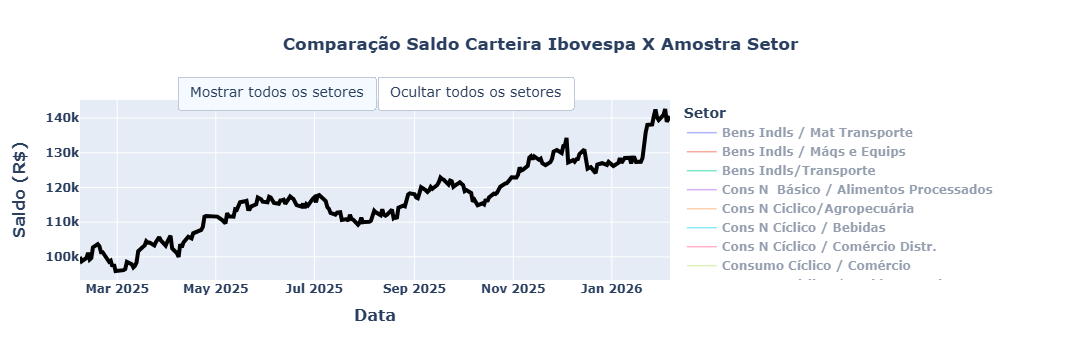

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_setor_retorno.html


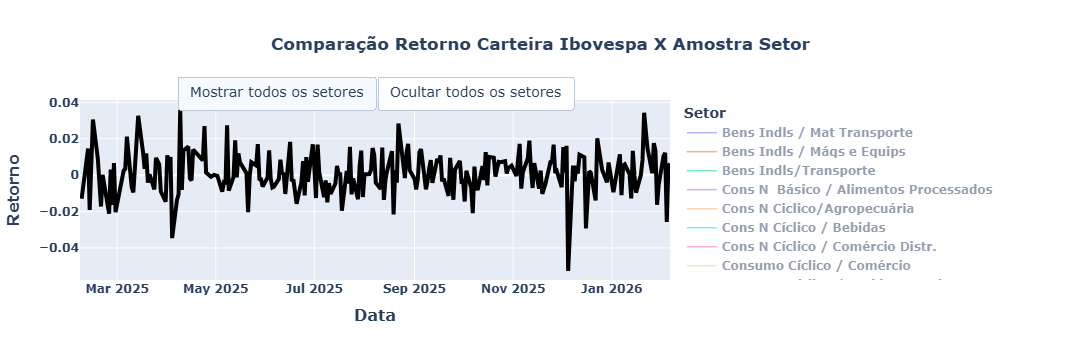

10370450

In [50]:
# Gerar, salvar e abrir html
html_ibov_amostragem_setor = plot_amostragem_por_grupo_completo(resultados_por_setor_ibov, carteira_ibov, "setor", "Ibovespa")
saida = Path("resultados/html_indice_ibovespa_x_amostra_setor.html")
saida.write_text(html_ibov_amostragem_setor, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

#### SMALL

In [51]:
resultados_por_setor_small = amostragem_agrupamento(df_small, df_retornos_acumulado_small, "setor")


===== Grupo: Bens Indls / Mat Transporte =====
Serão escolhidas 6 ações
Ações escolhidas: ['POMO4.SA', 'FRAS3.SA', 'TUPY3.SA', 'RAPT4.SA', 'RCSL4.SA', 'RCSL3.SA']

===== Grupo: Bens Indls / Máqs e Equips =====
Serão escolhidas 1 ações
Ações escolhidas: ['KEPL3.SA']

===== Grupo: Bens Indls / Serviços =====
Serão escolhidas 2 ações
Ações escolhidas: ['GGPS3.SA', 'VLID3.SA']

===== Grupo: Bens Indls/Transporte =====
Serão escolhidas 4 ações
Ações escolhidas: ['ECOR3.SA', 'HBSA3.SA', 'TGMA3.SA', 'JSLG3.SA']

===== Grupo: Bens Industriais / Constr e Engenh =====
Serão escolhidas 3 ações
Ações escolhidas: ['MILS3.SA', 'PRNR3.SA', 'ARML3.SA']

===== Grupo: Comput e Equips =====
Serão escolhidas 2 ações
Ações escolhidas: ['INTB3.SA', 'POSI3.SA']

===== Grupo: Cons N  Básico / Alimentos Processados =====
Serão escolhidas 4 ações
Ações escolhidas: ['BEEF3.SA', 'SMTO3.SA', 'MDIA3.SA', 'CAML3.SA']

===== Grupo: Cons N Ciclico/Agropecuária =====
Serão escolhidas 4 ações
Ações escolhidas: ['SLCE3.

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_setor_saldo.html


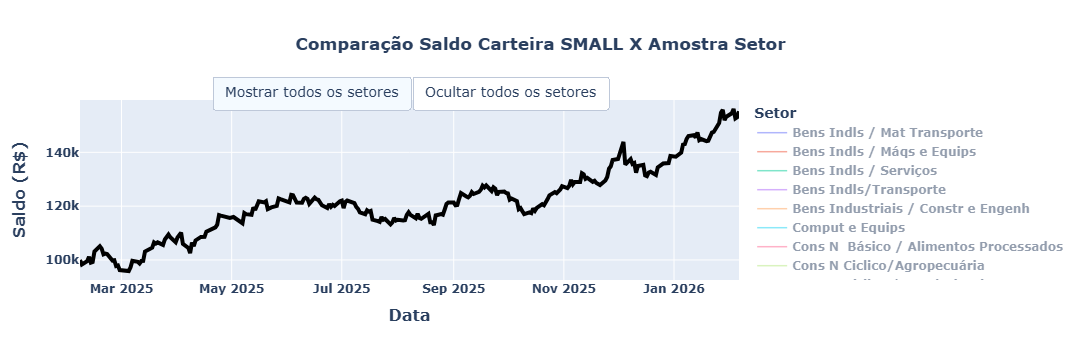

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_setor_retorno.html


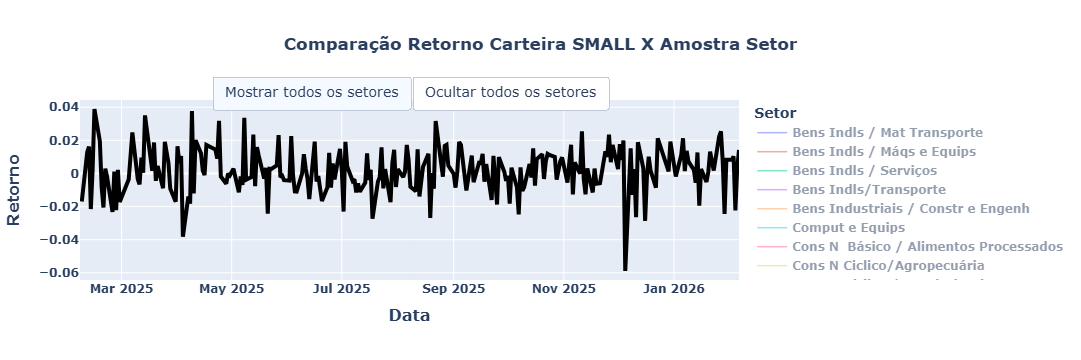

10439515

In [52]:
# Gerar, salvar e abrir html
html_small_amostragem_setor = plot_amostragem_por_grupo_completo(resultados_por_setor_small, carteira_small, "setor", "SMALL")
saida = Path("resultados/html_indice_small_x_amostra_setor.html")
saida.write_text(html_small_amostragem_setor, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

#### IBrA

In [53]:
resultados_por_setor_ibra = amostragem_agrupamento(df_ibra, df_retornos_acumulado_ibra, "setor")


===== Grupo: Bens Indls / Mat Transporte =====
Serão escolhidas 6 ações
Ações escolhidas: ['POMO4.SA', 'FRAS3.SA', 'TUPY3.SA', 'RAPT4.SA', 'RCSL4.SA', 'RCSL3.SA']

===== Grupo: Bens Indls / Máqs e Equips =====
Serão escolhidas 2 ações
Ações escolhidas: ['WEGE3.SA', 'KEPL3.SA']

===== Grupo: Bens Indls / Serviços =====
Serão escolhidas 2 ações
Ações escolhidas: ['GGPS3.SA', 'VLID3.SA']

===== Grupo: Bens Indls/Transporte =====
Serão escolhidas 5 ações
Ações escolhidas: ['RAIL3.SA', 'ECOR3.SA', 'HBSA3.SA', 'TGMA3.SA', 'JSLG3.SA']

===== Grupo: Bens Industriais / Constr e Engenh =====
Serão escolhidas 3 ações
Ações escolhidas: ['MILS3.SA', 'PRNR3.SA', 'ARML3.SA']

===== Grupo: Comput e Equips =====
Serão escolhidas 2 ações
Ações escolhidas: ['INTB3.SA', 'POSI3.SA']

===== Grupo: Cons N  Básico / Alimentos Processados =====
Serão escolhidas 5 ações
Ações escolhidas: ['MBRF3.SA', 'BEEF3.SA', 'SMTO3.SA', 'MDIA3.SA', 'CAML3.SA']

===== Grupo: Cons N Ciclico/Agropecuária =====
Serão escolhida

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_setor_saldo.html


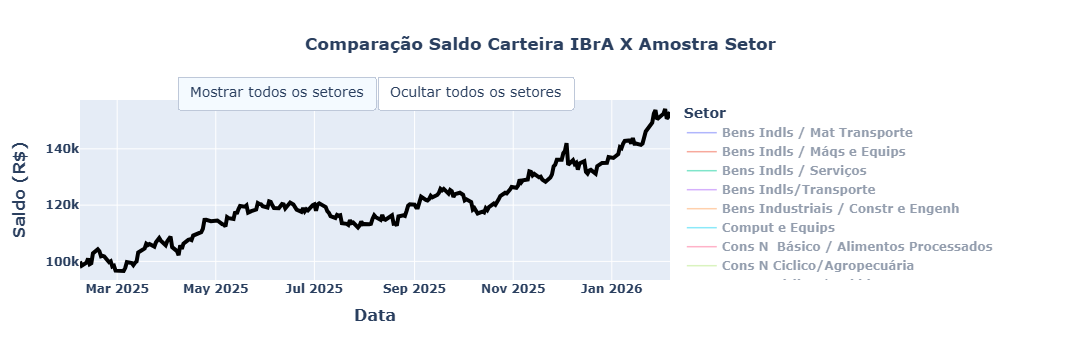

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_setor_retorno.html


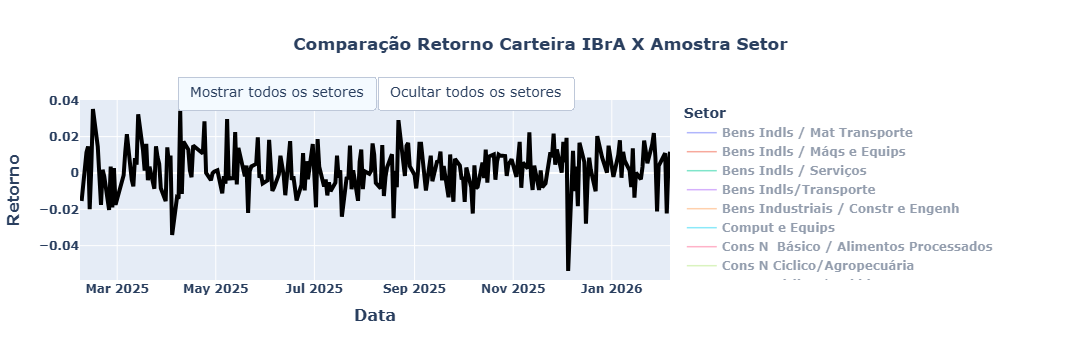

10486887

In [54]:
# Gerar, salvar e abrir html
html_ibra_amostragem_setor = plot_amostragem_por_grupo_completo(resultados_por_setor_ibra, carteira_ibra, "setor", "IBrA")
saida = Path("resultados/html_indice_ibra_x_amostra_setor.html")
saida.write_text(html_ibra_amostragem_setor, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

#### Juntando todos as comparações de índice 

In [55]:
# Salvar e abrir
html_todos_indices_amostragem_por_setor = html_amostragem_todos_indices("setor")
saida = Path("resultados/comparacoes_todos_indices_x_amostragem_setor.html")
saida.write_text(html_todos_indices_amostragem_por_setor, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

2475

### Grupo (Participação)

In [56]:
def amostragem_agrupamento_participacao(dataset, dataset_retornos_acumulados, n_grupos): 
    dataset = (
    dataset
    .assign(Código=dataset["Código"].astype(str).str.strip().str.upper() + ".SA")
    .loc[
        lambda x: 
            x["Código"].isin(dataset_retornos_acumulados.columns)
    ]
    )
    
    n_elementos = dataset.shape[0]
    intervalo = len(dataset) // n_grupos 

    grupos = []
    id_grupo = 0
    contagem = 0

    for _ in dataset.iterrows():
        grupos.append('Grupo ' + str (id_grupo + 1))
        contagem += 1
        if contagem > intervalo:
          contagem = 0
          id_grupo += 1

    dataset["Grupo"] = grupos

    dataset["Código"] = dataset["Código"].str.rstrip(".SA")

    print(dataset["Grupo"].value_counts())

    resultados = amostragem_agrupamento(dataset, dataset_retornos_acumulados, "grupo")

    return resultados

#### Ibovespa

In [57]:
resultados_por_grupo_ibov = amostragem_agrupamento_participacao(df_ibov, df_retornos_acumulado_ibov, 10)

Grupo
Grupo 1     8
Grupo 2     8
Grupo 3     8
Grupo 4     8
Grupo 5     8
Grupo 6     8
Grupo 7     8
Grupo 8     8
Grupo 9     8
Grupo 10    7
Name: count, dtype: int64

===== Grupo: Grupo 1 =====
Serão escolhidas 8 ações
Ações escolhidas: ['VALE3.SA', 'ITUB4.SA', 'PETR4.SA', 'PETR3.SA', 'AXIA3.SA', 'BBDC4.SA', 'SBSP3.SA', 'B3SA3.SA']

===== Grupo: Grupo 2 =====
Serão escolhidas 8 ações
Ações escolhidas: ['ITSA4.SA', 'BPAC11.SA', 'WEGE3.SA', 'BBAS3.SA', 'ABEV3.SA', 'EQTL3.SA', 'RENT3.SA', 'RDOR3.SA']

===== Grupo: Grupo 3 =====
Serão escolhidas 8 ações
Ações escolhidas: ['ENEV3.SA', 'PRIO3.SA', 'VBBR3.SA', 'RADL3.SA', 'SUZB3.SA', 'VIVT3.SA', 'UGPA3.SA', 'GGBR4.SA']

===== Grupo: Grupo 4 =====
Serão escolhidas 8 ações
Ações escolhidas: ['BBDC3.SA', 'BBSE3.SA', 'CPLE3.SA', 'CMIG4.SA', 'TIMS3.SA', 'TOTS3.SA', 'RAIL3.SA', 'ENGI11.SA']

===== Grupo: Grupo 5 =====
Serão escolhidas 8 ações
Ações escolhidas: ['AXIA6.SA', 'KLBN11.SA', 'LREN3.SA', 'ALOS3.SA', 'MBRF3.SA', 'SANB11.SA', 'EGIE3.S

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_grupo_saldo.html


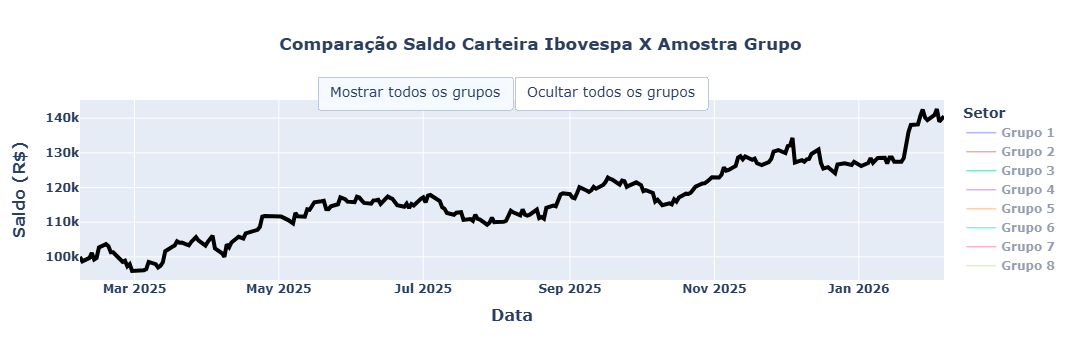

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_grupo_retorno.html


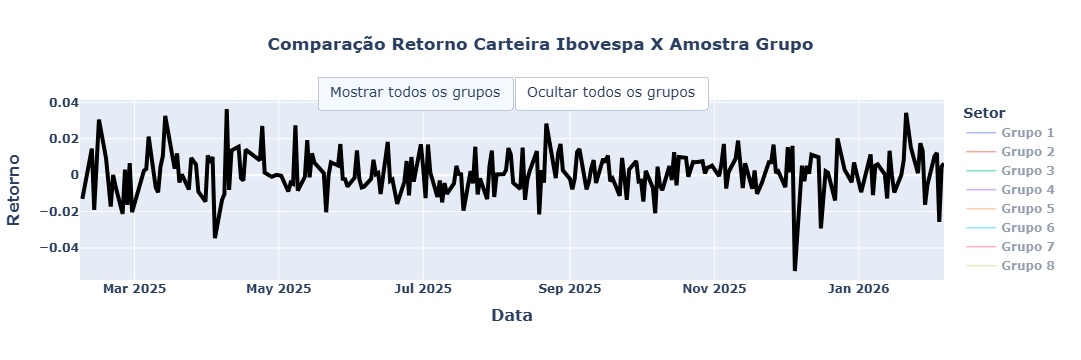

9951217

In [58]:
# Gerar, salvar e abrir html
html_ibov_amostragem_grupo = plot_amostragem_por_grupo_completo(resultados_por_grupo_ibov, carteira_ibov, "grupo", "Ibovespa")
saida = Path("resultados/html_indice_ibovespa_x_amostra_grupo.html")
saida.write_text(html_ibov_amostragem_grupo, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

#### SMALL

In [59]:
resultados_por_grupo_small = amostragem_agrupamento_participacao(df_small, df_retornos_acumulado_small, 10)

Grupo
Grupo 1     11
Grupo 2     11
Grupo 3     11
Grupo 4     11
Grupo 5     11
Grupo 6     11
Grupo 7     11
Grupo 8     11
Grupo 9     11
Grupo 10     9
Name: count, dtype: int64

===== Grupo: Grupo 1 =====
Serão escolhidas 11 ações
Ações escolhidas: ['LREN3.SA', 'ALOS3.SA', 'ASAI3.SA', 'MULT3.SA', 'CSAN3.SA', 'SMFT3.SA', 'CSMG3.SA', 'SAPR11.SA', 'TAEE11.SA', 'GOAU4.SA', 'BRAV3.SA']

===== Grupo: Grupo 2 =====
Serão escolhidas 11 ações
Ações escolhidas: ['GGPS3.SA', 'CYRE3.SA', 'HYPE3.SA', 'FLRY3.SA', 'COGN3.SA', 'CSNA3.SA', 'CURY3.SA', 'BRAP4.SA', 'IGTI11.SA', 'ALUP11.SA', 'DIRR3.SA']

===== Grupo: Grupo 3 =====
Serão escolhidas 11 ações
Ações escolhidas: ['IRBR3.SA', 'POMO4.SA', 'ORVR3.SA', 'MGLU3.SA', 'AURE3.SA', 'BRSR6.SA', 'VIVA3.SA', 'ECOR3.SA', 'YDUQ3.SA', 'SLCE3.SA', 'TEND3.SA']

===== Grupo: Grupo 4 =====
Serão escolhidas 11 ações
Ações escolhidas: ['HAPV3.SA', 'MRVE3.SA', 'AZZA3.SA', 'USIM5.SA', 'UNIP6.SA', 'ODPV3.SA', 'RECV3.SA', 'BEEF3.SA', 'JHSF3.SA', 'CEAB3.SA', 'ONCO3

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_grupo_saldo.html


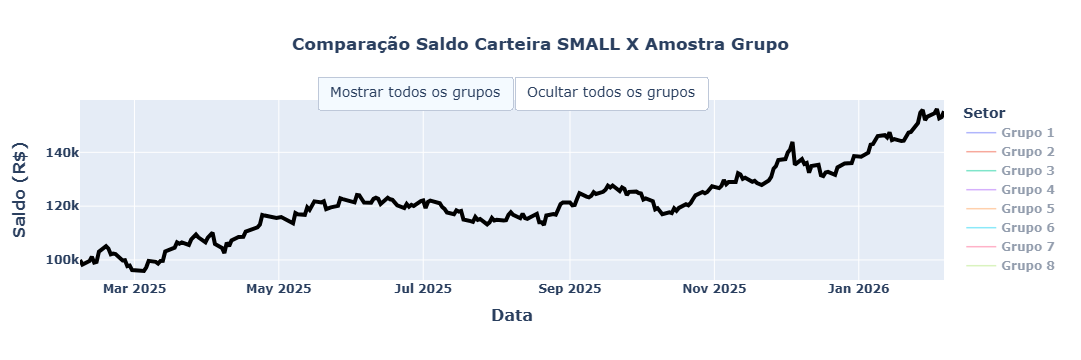

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_grupo_retorno.html


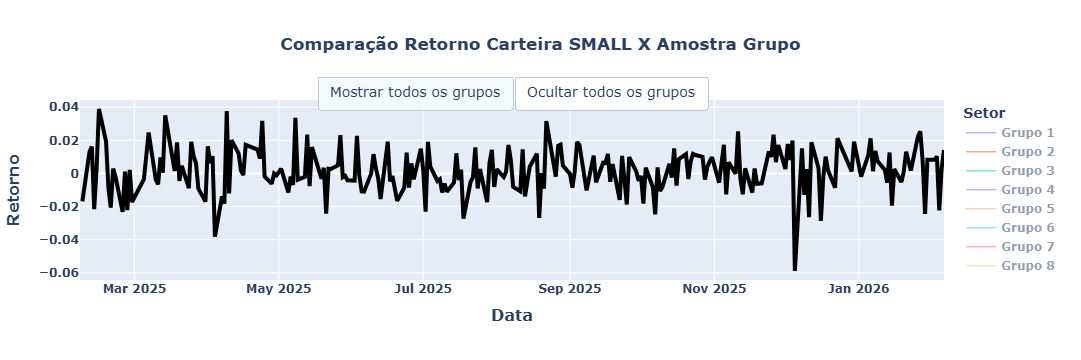

9951500

In [60]:
# Gerar, salvar e abrir html
html_small_amostragem_grupo = plot_amostragem_por_grupo_completo(resultados_por_grupo_small, carteira_small, "grupo", "SMALL")
saida = Path("resultados/html_indice_small_x_amostra_grupo.html")
saida.write_text(html_small_amostragem_grupo, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

#### IBrA

In [61]:
resultados_por_grupo_ibra = amostragem_agrupamento_participacao(df_ibra, df_retornos_acumulado_ibra, 10)

Grupo
Grupo 1     16
Grupo 2     16
Grupo 3     16
Grupo 4     16
Grupo 5     16
Grupo 6     16
Grupo 7     16
Grupo 8     16
Grupo 9     16
Grupo 10     8
Name: count, dtype: int64

===== Grupo: Grupo 1 =====
Serão escolhidas 16 ações
Ações escolhidas: ['VALE3.SA', 'ITUB4.SA', 'PETR4.SA', 'PETR3.SA', 'AXIA3.SA', 'BBDC4.SA', 'SBSP3.SA', 'B3SA3.SA', 'BPAC11.SA', 'ITSA4.SA', 'WEGE3.SA', 'BBAS3.SA', 'ABEV3.SA', 'EQTL3.SA', 'RENT3.SA', 'RDOR3.SA']

===== Grupo: Grupo 2 =====
Serão escolhidas 16 ações
Ações escolhidas: ['ENEV3.SA', 'CPLE3.SA', 'PRIO3.SA', 'VBBR3.SA', 'RADL3.SA', 'SUZB3.SA', 'VIVT3.SA', 'UGPA3.SA', 'GGBR4.SA', 'BBDC3.SA', 'BBSE3.SA', 'CMIG4.SA', 'TIMS3.SA', 'TOTS3.SA', 'ITUB3.SA', 'RAIL3.SA']

===== Grupo: Grupo 3 =====
Serão escolhidas 16 ações
Ações escolhidas: ['ENGI11.SA', 'AXIA6.SA', 'KLBN11.SA', 'LREN3.SA', 'ALOS3.SA', 'MBRF3.SA', 'SANB11.SA', 'EGIE3.SA', 'ASAI3.SA', 'ISAE4.SA', 'CXSE3.SA', 'MULT3.SA', 'CSAN3.SA', 'SMFT3.SA', 'CSMG3.SA', 'CMIN3.SA']

===== Grupo: Grupo

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_grupo_saldo.html


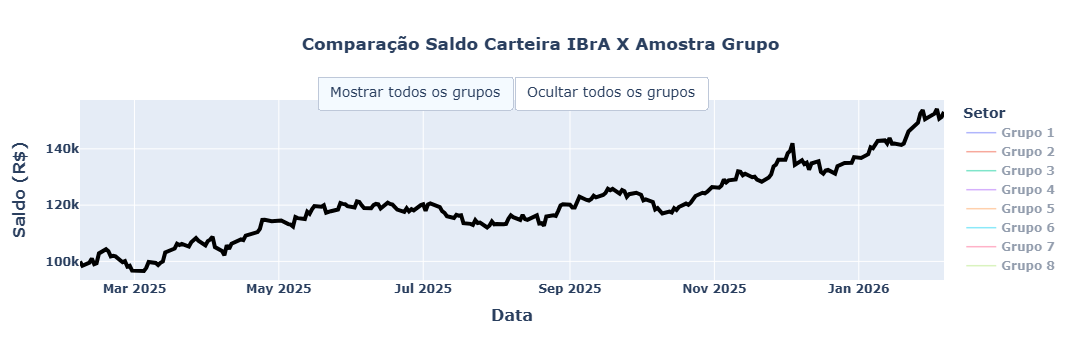

HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_grupo_retorno.html


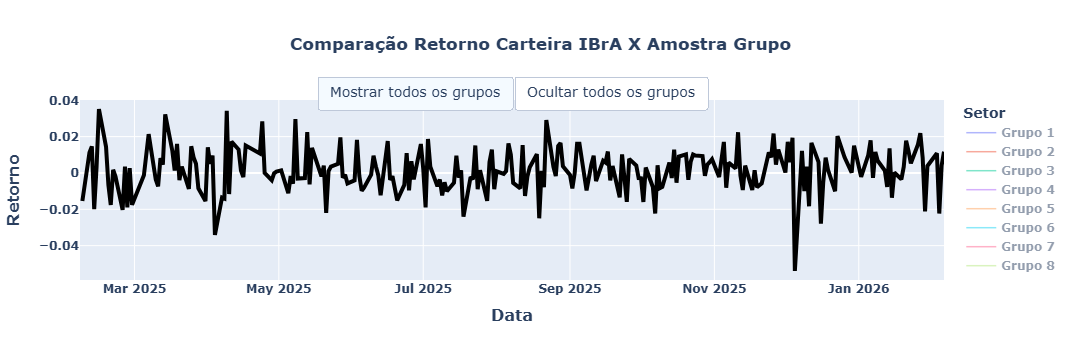

9951061

In [62]:
# Gerar, salvar e abrir html
html_ibra_amostragem_grupo = plot_amostragem_por_grupo_completo(resultados_por_grupo_ibra, carteira_ibra, "grupo", "IBrA")
saida = Path("resultados/html_indice_ibra_x_amostra_grupo.html")
saida.write_text(html_ibra_amostragem_grupo, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

#### Juntando todos as comparações de índice 

In [63]:
# Salvar e abrir
html_todos_indices_amostragem_por_grupo = html_amostragem_todos_indices("grupo")
saida = Path("resultados/comparacoes_todos_indices_x_amostragem_grupo.html")
saida.write_text(html_todos_indices_amostragem_por_grupo, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

2475

## Amostragem estratificada

Para a amostragem estratificada será utilizada a participação. Serão criadas 3 categorias de Participação:
- Alta: Maior ou igual a 1%
- Média: Menor que 1% e maior que 0.1%
- Baixa: Menor ou igual a 0.1%

In [64]:
def amostragem_estratificada_participacao(dataset, dataset_retornos_acumulados, percentual):     
    # Regras (condições)
    condicoes = [
        dataset["Part. (%)"] >= 1,
        (dataset["Part. (%)"] > 0.1) & (dataset["Part. (%)"] < 1),
        dataset["Part. (%)"] <= 0.1
    ]
    
    # Valores correspondentes para cada condição
    valores = ["Alta (>=1%)", "Média (0.1-1%)", "Baixa (<=0.1%)"]
    
    # Cria a coluna Participação
    dataset["Participação"] = np.select(condicoes, valores, default="Sem info").astype(object)

    # Transforma a coluna em Categorical com ordem
    dataset["Participação"] = pd.Categorical(dataset["Participação"],
                                         categories=valores,
                                         ordered=True)
    
    dataset = (
    dataset
    .assign(Código=dataset["Código"].astype(str).str.strip().str.upper() + ".SA")
    .loc[
        lambda x: 
            x["Código"].isin(dataset_retornos_acumulados.columns)
    ]
    )

    print(f"\nOriginal\n{dataset["Participação"].value_counts().sort_index()}")
    
    split = StratifiedShuffleSplit(test_size=percentual, random_state=seed)
    for _, y in split.split(dataset, dataset['Participação']):
        df_y = dataset.iloc[y]

    tickets_selecionados = df_y["Código"]

    dataset_retornos_acumulados = dataset_retornos_acumulados[tickets_selecionados]

    # Considerando um investimento de 100000 reais igualmente divido entre as ações
    # OBS: para facilitar, estamos ignorando o fato de não ser possível comprar de forma fracionária as ações
    valor_por_acao = np.round(100000/dataset_retornos_acumulados.shape[1],2)
    dataset_retornos_acumulados = dataset_retornos_acumulados*valor_por_acao
    dataset_retornos_acumulados['saldo'] = dataset_retornos_acumulados.sum(axis=1)
    dataset_retornos_acumulados["retorno"] = dataset_retornos_acumulados['saldo'].pct_change()
    
    print(f"\nEstratificação\n{df_y["Participação"].value_counts().sort_index()}")

    return dataset_retornos_acumulados

### Ibovespa

In [65]:
carteira_amostra_estratificada_ibov = amostragem_estratificada_participacao(df_ibov, df_retornos_acumulado_ibov, 0.5)


Original
Participação
Alta (>=1%)       24
Média (0.1-1%)    50
Baixa (<=0.1%)     5
Name: count, dtype: int64

Estratificação
Participação
Alta (>=1%)       12
Média (0.1-1%)    25
Baixa (<=0.1%)     3
Name: count, dtype: int64


HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibovespa_x_amostra_estratificada.html


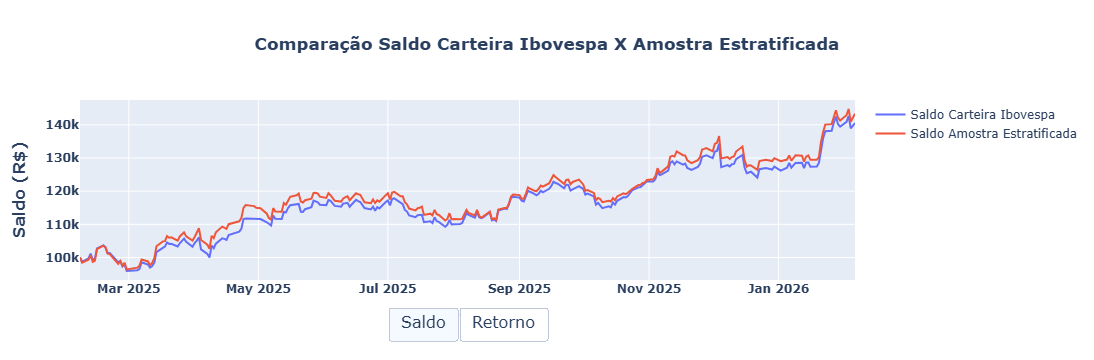

In [66]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_ibov, carteira_amostra_estratificada_ibov,"estratificada", "Ibovespa")

### SMALL

In [67]:
carteira_amostra_estratificada_small = amostragem_estratificada_participacao(df_small, df_retornos_acumulado_small, 0.5)


Original
Participação
Alta (>=1%)       30
Média (0.1-1%)    69
Baixa (<=0.1%)     9
Name: count, dtype: int64

Estratificação
Participação
Alta (>=1%)       15
Média (0.1-1%)    35
Baixa (<=0.1%)     4
Name: count, dtype: int64


HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_small_x_amostra_estratificada.html


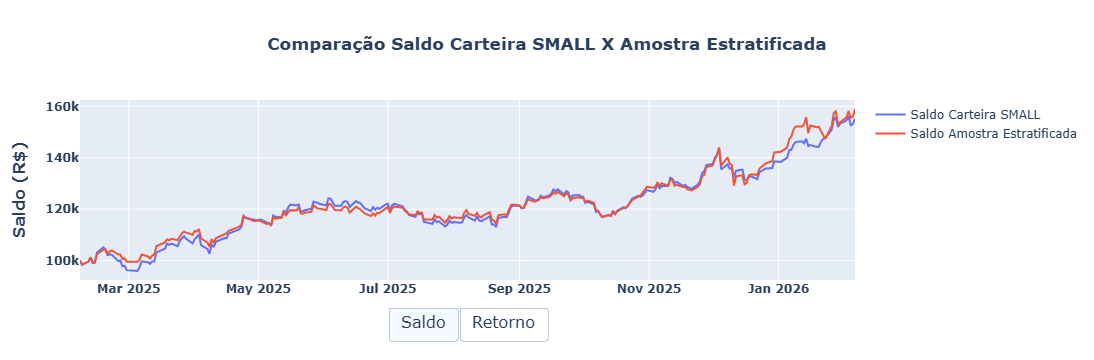

In [68]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_small, carteira_amostra_estratificada_small,"estratificada", "SMALL")

### IBrA

In [69]:
carteira_amostra_estratificada_ibra = amostragem_estratificada_participacao(df_ibra, df_retornos_acumulado_ibra, 0.5)


Original
Participação
Alta (>=1%)       22
Média (0.1-1%)    62
Baixa (<=0.1%)    68
Name: count, dtype: int64

Estratificação
Participação
Alta (>=1%)       11
Média (0.1-1%)    31
Baixa (<=0.1%)    34
Name: count, dtype: int64


HTML interativo criado: C:\Users\mht-1\OneDrive\Documentos\Projetos\Dados\amostragem_bolsa_brasileira\resultados\html_indice_ibra_x_amostra_estratificada.html


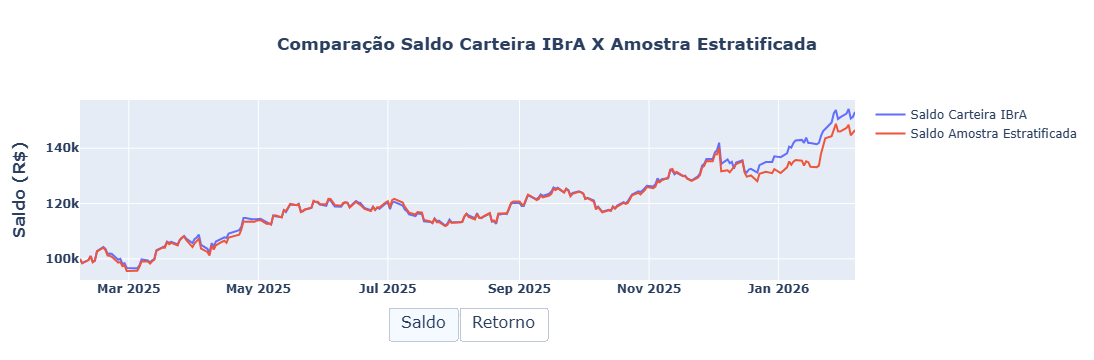

In [70]:
# Gera o HTML com o índice e a amostra
plot_amostragem(carteira_ibra, carteira_amostra_estratificada_ibra,"estratificada", "IBrA")

### Juntando todos as comparações de índice 

In [71]:
# Salvar e abrir
html_todos_indices_amostragem_estratificada = html_amostragem_todos_indices("estratificada")
saida = Path("resultados/comparacoes_todos_indices_x_amostragem_estratificada.html")
saida.write_text(html_todos_indices_amostragem_estratificada, encoding="utf-8")
#webbrowser.open(saida.resolve().as_uri())

2499

## Resultados Consolidados

In [72]:
# Lista dos HTML's gerados anteriormente
arquivos_html = [
    'comparacoes_todos_indices_x_amostragem_simples.html',
    'comparacoes_todos_indices_x_amostragem_sistematica.html',
    'comparacoes_todos_indices_x_amostragem_setor.html',
    'comparacoes_todos_indices_x_amostragem_grupo.html',
    'comparacoes_todos_indices_x_amostragem_estratificada.html'
]

# Nome das abas
nomes_abas = [
    "Simples",
    "Sistemática",
    "Agrupamento (Setor)",
    "Agrupamento (Participação)" ,
    "Estratificada (Participação)"
]

# HTML consolidado
html_final = """
<!DOCTYPE html>
<html lang="pt-br">
<head>
<meta charset="UTF-8">

<style>
html, body {
    width: 100%;
    height: 100%;
    margin: 0;
}

body {
    display: flex;
    flex-direction: column;
    font-family: Arial;
    background: #f8f9fa;
    margin: 0;
    height: 100vh;
}

.tabs {
    display: flex;       
    flex-direction: row; 
    justify-content: center; 
    padding: 12px;
    background: transparent;
}

.tab-button {
    background: #4C72B0;
    color: white;
    border: 1px solid #000;
    padding: 10px 20px;
    margin-right: 8px;   /* espaçamento horizontal entre botões */
    cursor: pointer;
    border-radius: 6px;
}

.tab-button.active {
    background: #2A4A7C;
    font-weight: bold;
}

.tab-container {
    flex: 1;            /* ocupa todo o restante da tela */
    position: relative;
    overflow: hidden;
}

.tab-content {
    position: absolute;
    inset: 0;
    opacity: 0;
    pointer-events: none;
    transition: opacity 0.15s ease;
}

.tab-content.active {
    opacity: 1;
    pointer-events: auto;
    z-index: 1;
}

iframe {
    width: 100%;
    height: 100%;
    border: none;
}
</style>
</head>

<body>

<div class="tabs">
"""

# Insere os botões
for i, nome in enumerate(nomes_abas):
    active = "active" if i == 0 else ""
    html_final += f"""
    <button class="tab-button {active}" onclick="openTab({i})">{nome}</button>
    """

html_final += """
</div>

<div class="tab-container">
"""

# Insere os gráficos
for i, arquivo in enumerate(arquivos_html):
    active = "active" if i == 0 else ""
    html_final += f"""
    <div class="tab-content {active}">
        <iframe src="{arquivo}"></iframe>
    </div>
    """

# JS
html_final += """
</div>

<script>
function openTab(index) {
    const tabs = document.querySelectorAll('.tab-content');
    const buttons = document.querySelectorAll('.tab-button');

    tabs.forEach((t, i) => {
        t.classList.toggle('active', i === index);
    });

    buttons.forEach((b, i) => {
        b.classList.toggle('active', i === index);
    });
}
</script>

</body>
</html>
"""

In [73]:
saida = Path("resultados/comparacoes_indices_x_amostragens_consolidado.html")
saida.write_text(html_final, encoding="utf-8")
webbrowser.open(saida.resolve().as_uri())

True

In [74]:
# Função para gerar um index para usar no Github
def gerar_index_html(destino="index.html", html_apontado="resultados/comparacoes_indices_x_amostragens_consolidado.html"):

    html_conteudo = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>Index</title>
        <style>
            html, body {{
                margin: 0;
                padding: 0;
                width: 100%;
                height: 100%;
            }}
            iframe {{
                width: 100%;
                height: 100%;
                border: none;
            }}
        </style>
    </head>
    <body>
        <iframe src="{html_apontado}"></iframe>
    </body>
    </html>
    """
    
    Path(destino).write_text(html_conteudo, encoding="utf-8")
    print(f"{destino} gerado com sucesso, apontando para '{html_apontado}'")

# Chamando função para gerar o index 
gerar_index_html()

index.html gerado com sucesso, apontando para 'resultados/comparacoes_indices_x_amostragens_consolidado.html'
